# Packages

In [1]:
# !pip install scikit-misc
# !pip install plotnine
# !pip install statsmodels

In [2]:
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from scipy.interpolate import make_interp_spline
from plotnine import *
from matplotlib.colors import to_rgba

# Functions

## Data Cleaning

In [3]:
def parse_filename_components(df_dict):
    """Adds columns for trial number and time range extracted from filenames"""
    for name, df in df_dict.items():
        # Extract components using regular expression
        match = re.match(r'^(\d+)(.*?)_(IMU|MoCap)_(\d+s)_to_(\d+s)$', name)
        
        if match:
            # Add new columns
            df['TrialNumber'] = int(match.group(1))  # First number in filename
            df['TimeRange'] = f"{match.group(4)}-{match.group(5)}"  # Time range
            df['Duration'] = float(match.group(5).replace('s','')) - float(match.group(4).replace('s',''))
        else:
            print(f"Warning: Filename format not recognized for {name}")
            df['TrialNumber'] = None
            df['TimeRange'] = None
            df['Duration'] = None
    
    return df_dict

## Data Manipulation

## Rounding to nearest 0.001s Method

In [4]:
def align_imu_mocap_data(imu_df, mocap_df):
    """
    Aligns IMU and MoCap data by:
    1. Rounding timestamps to the nearest 0.001s.
    2. Aggregating (mean) degree measures at each rounded time.
    3. Merging the two datasets on the rounded timestamps.
    4. Dropping rows with missing values.
    
    Args:
        imu_df: DataFrame containing IMU data.
        mocap_df: DataFrame containing MoCap data.
        
    Returns:
        merged_df: Aligned DataFrame with both IMU and MoCap data.
    """
    # Make copies to avoid modifying originals
    imu = imu_df.copy()
    mocap = mocap_df.copy()
    
    # Round time to nearest 0.01s
    imu['AlignedTime'] = imu['Shifted Time (s)'].round(2)
    mocap['AlignedTime'] = mocap['Time (s)'].round(2)
    
    # Aggregate (mean) degree measures at each rounded time
    imu_agg = imu.groupby('AlignedTime').agg({
        'Angle IMU (degrees)': 'mean',
        'TrialNumber': 'first',
        'TimeRange': 'first',
        'Duration': 'first',
        'Device': 'first',
        'Filename': 'first'
    }).reset_index()
    
    mocap_agg = mocap.groupby('AlignedTime').agg({
        'Angle MoCap (degrees)': 'mean',
        'TrialNumber': 'first',
        'TimeRange': 'first',
        'Duration': 'first',
        'Device': 'first',
        'Filename': 'first'
    }).reset_index()
    
    # Merge IMU and MoCap data on aligned time
    merged_df = pd.merge(
        imu_agg,
        mocap_agg,
        on=['AlignedTime', 'TrialNumber'],
        suffixes=('_IMU', '_MoCap')
    )
    
    # Drop rows where either IMU or MoCap data is missing
    merged_df = merged_df.dropna()
    
    merged_df = merged_df[['AlignedTime', 
                           'TrialNumber', 
                           'Angle IMU (degrees)', 
                           'Angle MoCap (degrees)', 
                           'Filename_IMU', 
                           'Filename_MoCap']]

    return merged_df

## Common Time Sequence Method

In [5]:
def align_imu_mocap_data_seq(imu_df, mocap_df, time_window=0.005):
    """
    Aligns IMU and MoCap data by resampling to a common time sequence.
    
    Args:
        imu_df: DataFrame containing IMU data.
        mocap_df: DataFrame containing MoCap data.
        time_window: Half-width of the averaging window in seconds.
    
    Returns:
        aligned_df: Combined DataFrame with aligned data.
    """
    # Extract time ranges (should be the same for IMU and MoCap)
    start_time = max(imu_df['Shifted Time (s)'].min(), mocap_df['Time (s)'].min())
    end_time = min(imu_df['Shifted Time (s)'].max(), mocap_df['Time (s)'].max())
    
    # Create common time sequence (e.g., 0.001s intervals)
    common_time = np.arange(start_time, end_time + 0.001, 0.001)
    
    # Initialize arrays to store aligned data
    aligned_imu = np.full_like(common_time, np.nan)
    aligned_mocap = np.full_like(common_time, np.nan)
    
    # Vectorized window calculations
    for i, t in enumerate(common_time):
        # IMU window mask
        imu_mask = (imu_df['Shifted Time (s)'] >= t - time_window) & \
                   (imu_df['Shifted Time (s)'] <= t + time_window)
        # MoCap window mask
        mocap_mask = (mocap_df['Time (s)'] >= t - time_window) & \
                      (mocap_df['Time (s)'] <= t + time_window)
        
        # Calculate means if data exists in window
        if imu_mask.any():
            aligned_imu[i] = imu_df.loc[imu_mask, 'Angle IMU (degrees)'].mean()
        if mocap_mask.any():
            aligned_mocap[i] = mocap_df.loc[mocap_mask, 'Angle MoCap (degrees)'].mean()
    
    # Create mask for valid entries (where both IMU and MoCap have data)
    valid_mask = ~np.isnan(aligned_imu) & ~np.isnan(aligned_mocap)
    
    # Create aligned DataFrame
    aligned_df = pd.DataFrame({
        'AlignedTime': np.round(common_time[valid_mask], 3),
        'TrialNumber': imu_df['TrialNumber'].iloc[0],
        'Angle IMU (degrees)': aligned_imu[valid_mask],
        'Angle MoCap (degrees)': aligned_mocap[valid_mask],
        'Filename_IMU': imu_df['Filename'].iloc[0],
        'Filename_MoCap': mocap_df['Filename'].iloc[0],
    })
    
    return aligned_df

## Visualizations

In [6]:
def plot_all_device_data(aligned_data, motion_name, device_type='IMU'):
    """
    Plot all trials for one device type using ggplot style
    
    Args:
        aligned_data: Dictionary of aligned DataFrames
        motion_name: Name of the motion
        device_type: 'IMU' or 'MoCap'
    """
    # Combine all trials into one DataFrame
    plot_data = []
    for trial_num, df in aligned_data.items():
        temp = df[['AlignedTime', f'Angle {device_type} (degrees)']].copy()
        temp['Trial'] = f'Trial {trial_num}'
        plot_data.append(temp)
    
    combined = pd.concat(plot_data)
    combined = combined.rename(columns={
        'AlignedTime': 'Time',
        f'Angle {device_type} (degrees)': 'Angle'
    })
    
    plot = (
        ggplot(combined, aes(x='Time', y='Angle', color='Trial')) +
        geom_line(size=1, alpha=0.7) +
        labs(
            title=f'{motion_name} - All {device_type} Trials',
            x='Aligned Time (s)',
            y='Angle (degrees)'
        ) +
        theme_bw() +
        theme(
            figure_size=(12, 6),
            legend_position='right',
            legend_title=element_blank()
        )
    )
    return plot

def plot_differences_gg(aligned_data, motion_name, smooth=True):
    """
    Difference plot using ggplot-style with geom_smooth()

    Args:
        aligned_data: Dictionary of aligned DataFrames
        motion_name: Name of the motion
        smooth: Add an overall smoothing spline
    """
    # Prepare difference data
    diff_data = []
    for trial_num, df in aligned_data.items():
        temp = df[['AlignedTime']].copy()
        temp['Difference'] = df['Angle MoCap (degrees)'] - df['Angle IMU (degrees)']
        temp['Trial'] = f'Trial {trial_num}'
        diff_data.append(temp)
    
    combined = pd.concat(diff_data)
    
    # Base plot
    plot = (
        ggplot(combined, aes(x='AlignedTime', y='Difference')) +
        geom_hline(yintercept=0, linetype='dashed', color='gray', alpha=0.5) +
        labs(
            title=f'{motion_name} - MoCap vs IMU Differences',
            x='Aligned Time (s)',
            y='Difference (degrees)'
        ) +
        theme_bw() +
        theme(figure_size=(12, 6))
    )
    
    if not smooth:
        # Individual trial lines with colors
        plot += geom_line(aes(color='Trial'), size=.85, alpha=0.5)
    else:
        # Faint individual lines
        plot += geom_line(aes(group='Trial'), color='gray', size=.85, alpha=0.15)
    
    if smooth:
        plot += geom_smooth(
            aes(group=1),  # Treat all data as one group
            method='loess',
            color='red',
            size=1.5,
            alpha=0.8,
            span=0.3,  # Controls smoothness (0-1; 1 = most smooth)
            se = False
        )
    
    return plot

def plot_single_trial_comparison_gg(aligned_data, motion_name, trial_num, 
                                  gap_threshold=0.15,
                                  highlight_thresholds=None,
                                  highlight_color='red',
                                  highlight_alpha=0.2):
    if trial_num not in aligned_data:
        raise ValueError(f"Trial {trial_num} not found")
    
    df = aligned_data[trial_num].copy()
    
    # Add gap indicators
    df = df.sort_values('AlignedTime')
    df['time_diff'] = df['AlignedTime'].diff()
    df['new_group'] = (df['time_diff'] > gap_threshold).cumsum()
    
    # Base plot
    plot = (
        ggplot(df, aes(x='AlignedTime')) +
        geom_line(aes(y='Angle IMU (degrees)', color='"IMU"', group='new_group'), size=0.85) +
        geom_line(aes(y='Angle MoCap (degrees)', color='"MoCap"', group='new_group'), size=0.85) +
        labs(title=f'{motion_name} - Trial {trial_num}') +
        scale_color_manual(values=["blue", "green"]) +
        theme_bw()
    )
    
    # Add threshold highlighting if requested
    if highlight_thresholds:
        lower, upper = highlight_thresholds
        
        # Create highlight regions
        highlight_df = pd.DataFrame({
            'xmin': df['AlignedTime'] - 0.005,
            'xmax': df['AlignedTime'] + 0.005,
            'ymin_upper': upper,
            'ymin_lower': -np.inf,
            'ymax_upper': np.inf,
            'ymax_lower': lower,
            'upper_highlight': (df['Angle IMU (degrees)'] > upper) | (df['Angle MoCap (degrees)'] > upper),
            'lower_highlight': (df['Angle IMU (degrees)'] < lower) | (df['Angle MoCap (degrees)'] < lower)
        })
        
        # Upper threshold highlights
        plot += geom_rect(
            data=highlight_df[highlight_df['upper_highlight']],
            mapping=aes(
                xmin='xmin',
                xmax='xmax',
                ymin='ymin_upper',
                ymax='ymax_upper'
            ),
            fill=highlight_color,
            alpha=highlight_alpha,
            inherit_aes=False
        )
        
        # Lower threshold highlights
        plot += geom_rect(
            data=highlight_df[highlight_df['lower_highlight']],
            mapping=aes(
                xmin='xmin', 
                xmax='xmax', 
                ymin='ymin_lower', 
                ymax='ymax_lower'
                ),
            fill=highlight_color,
            alpha=highlight_alpha,
            inherit_aes=False
        )
        
        # Threshold reference lines
        plot += geom_hline(yintercept=upper, linetype='dashed', color='black', alpha=0.5)
        plot += geom_hline(yintercept=lower, linetype='dashed', color='black', alpha=0.5)
        
    plot += labs(
        x='Aligned Time (s)',
        y='Difference (degrees)',
        color='Device'
        )
    
    return plot

# Data Read-in

In [7]:
# Get all csv files in the folder
folder_path = 'Aligned Data All Participants'

# Initialize separate dictionaries
axial_rotation = {}
flexion = {}
lateral_bending = {}

# Get all CSV files
all_files = glob.glob(os.path.join(folder_path, "*.csv"))

for file in all_files:
    try:
        # Get the filename without path or extension
        filename = os.path.splitext(os.path.basename(file))[0]
        
        # Read the CSV file
        df = pd.read_csv(file)

        # Add source column (IMU or MoCap)
        if 'IMU' in filename.upper():
            df['Device'] = 'IMU'
        elif 'MOCAP' in filename.upper():
            df['Device'] = 'MoCap'
        else:
            df['Device'] = 'Unknown'
            print(f"Warning: Couldn't determine source for {filename}")
        
        # Add filename as a column for reference
        df['Filename'] = filename 
        
        # Categorize based on filename
        if 'AxialRotation' in filename:
            axial_rotation[filename] = df
        elif 'Flexion' in filename:
            flexion[filename] = df
        elif 'LateralBending' in filename:
            lateral_bending[filename] = df
        else:
            print(f"File {filename} didn't match any category")
            
    except Exception as e:
        print(f"Error loading {file}: {str(e)}")

print(f"Loaded {len(axial_rotation)} AxialRotation files")
print(f"Loaded {len(flexion)} Flexion files")
print(f"Loaded {len(lateral_bending)} LateralBending files")

Loaded 52 AxialRotation files
Loaded 56 Flexion files
Loaded 54 LateralBending files


In [8]:
axial_rotation = parse_filename_components(axial_rotation)
flexion = parse_filename_components(flexion)
lateral_bending = parse_filename_components(lateral_bending)

# Time Matching

In [9]:
def process_motion(motion_dict, angle_col_name):
    """
    Processes a motion dictionary to align IMU/MoCap pairs with exact trial number matching.
    
    Args:
        motion_dict: Dictionary of DataFrames (axial_rotation, flexion, etc.)
        angle_col_name: Name of the angle column (e.g., 'AxialRotation Angle')
        
    Returns:
        Dictionary of aligned DataFrames keyed by trial number
    """
    aligned_data = {}
    
    # Create a lookup dictionary {trial_num: {device: df}}
    trial_lookup = {}
    for name, df in motion_dict.items():
        trial_num = df['TrialNumber'].iloc[0]
        device = 'IMU' if 'IMU' in name else 'MoCap'
        
        if trial_num not in trial_lookup:
            trial_lookup[trial_num] = {}
        trial_lookup[trial_num][device] = df
    
    # Process each trial
    for trial_num, devices in trial_lookup.items():
        try:
            if 'IMU' in devices and 'MoCap' in devices:
                # Standardize column names
                imu_df = devices['IMU'].rename(
                    columns={f'{angle_col_name} Angle IMU (degrees)': 'Angle IMU (degrees)'})
                mocap_df = devices['MoCap'].rename(
                    columns={f'{angle_col_name} Angle MoCap (degrees)': 'Angle MoCap (degrees)'})
                
                # Align data (uncommment desired method)
                aligned_df = align_imu_mocap_data(imu_df, mocap_df)
                # aligned_df = align_imu_mocap_data_seq(imu_df, mocap_df)
            
                aligned_data[trial_num] = aligned_df
            else:
                print(f"Trial {trial_num} missing {'IMU' if 'IMU' not in devices else 'MoCap'} data")
                
        except Exception as e:
            print(f"Error processing trial {trial_num}: {str(e)}")
    
    return aligned_data

# Process all motion types
aligned_axial = process_motion(axial_rotation, 'AxialRotation')
aligned_flexion = process_motion(flexion, 'Flexion')
aligned_lateral = process_motion(lateral_bending, 'LateralBending')

### Save Aligned Data

In [10]:
# for trial_num, df in aligned_axial.items():
#     df.to_csv(f"Modified Aligned Data All Participants/axial_rotation_trial_{trial_num}.csv", index=False)

# for trial_num, df in aligned_flexion.items():
#     df.to_csv(f"Modified Aligned Data All Participants/flexion_trial_{trial_num}.csv", index=False)

# for trial_num, df in aligned_lateral.items():
#     df.to_csv(f"Modified Aligned Data All Participants/lateral_trial_{trial_num}.csv", index=False)

### Load Aligned Data

In [11]:
# def load_aligned_data_from_csv(directory="Modified Aligned Data All Participants"):
#     """
#     Loads saved CSV files and reconstructs the original dictionary structure:
#     {
#         'axial_rotation': {trial_num: df, ...},
#         'flexion': {trial_num: df, ...},
#         'lateral_bending': {trial_num: df, ...}
#     }
#     """
#     aligned_data = {
#         'axial_rotation': {},
#         'flexion': {},
#         'lateral_bending': {}
#     }
    
#     # Map filename prefixes to dictionary keys
#     file_key_mapping = {
#         'axial_rotation': 'axial_rotation',
#         'flexion': 'flexion',
#         'lateral': 'lateral_bending'  # Adjust if filenames differ
#     }
    
#     for filename in os.listdir(directory):
#         if filename.endswith('.csv'):
#             # Extract motion type and trial number
#             parts = filename.split('_')
#             motion_type = parts[0]  # 'axial', 'flexion', 'lateral'
#             trial_num = int(parts[-1].replace('.csv', '').split('_')[-1])
            
#             # Find the correct dictionary key
#             for key in file_key_mapping:
#                 if key in filename:
#                     aligned_key = file_key_mapping[key]
#                     break
#             else:
#                 continue  # Skip unrecognized files
            
#             # Load CSV and store in dictionary
#             df = pd.read_csv(os.path.join(directory, filename))
#             aligned_data[aligned_key][trial_num] = df
    
#     return aligned_data

# # Load all data
# reconstructed_data = load_aligned_data_from_csv()

# # Access like before:
# aligned_axial = reconstructed_data['axial_rotation']
# aligned_flexion = reconstructed_data['flexion']
# aligned_lateral = reconstructed_data['lateral_bending']

# Visualizations

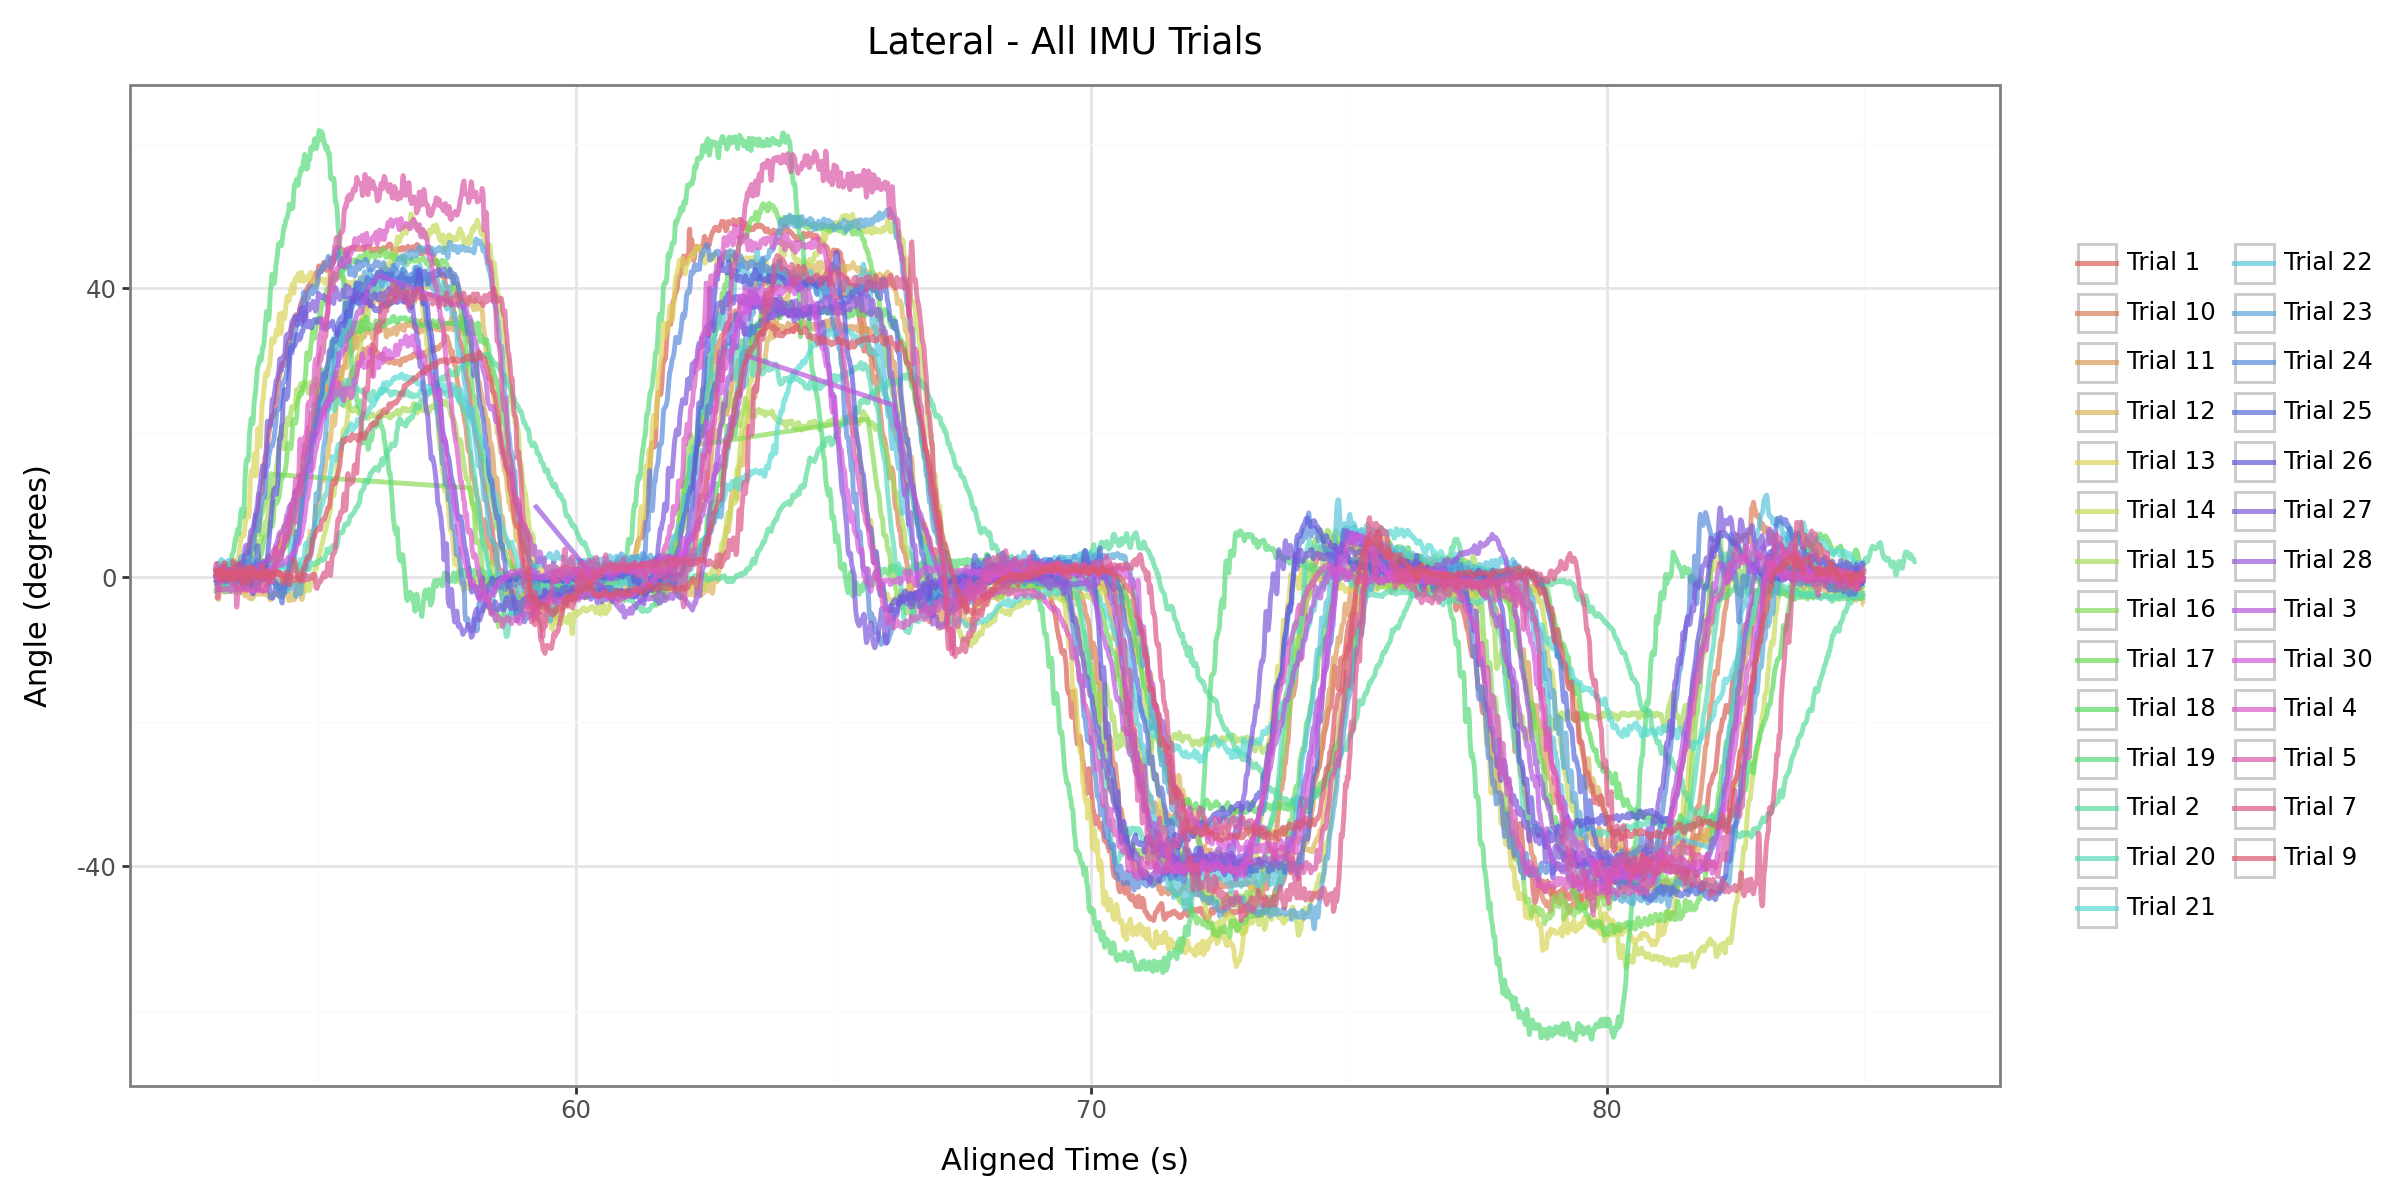

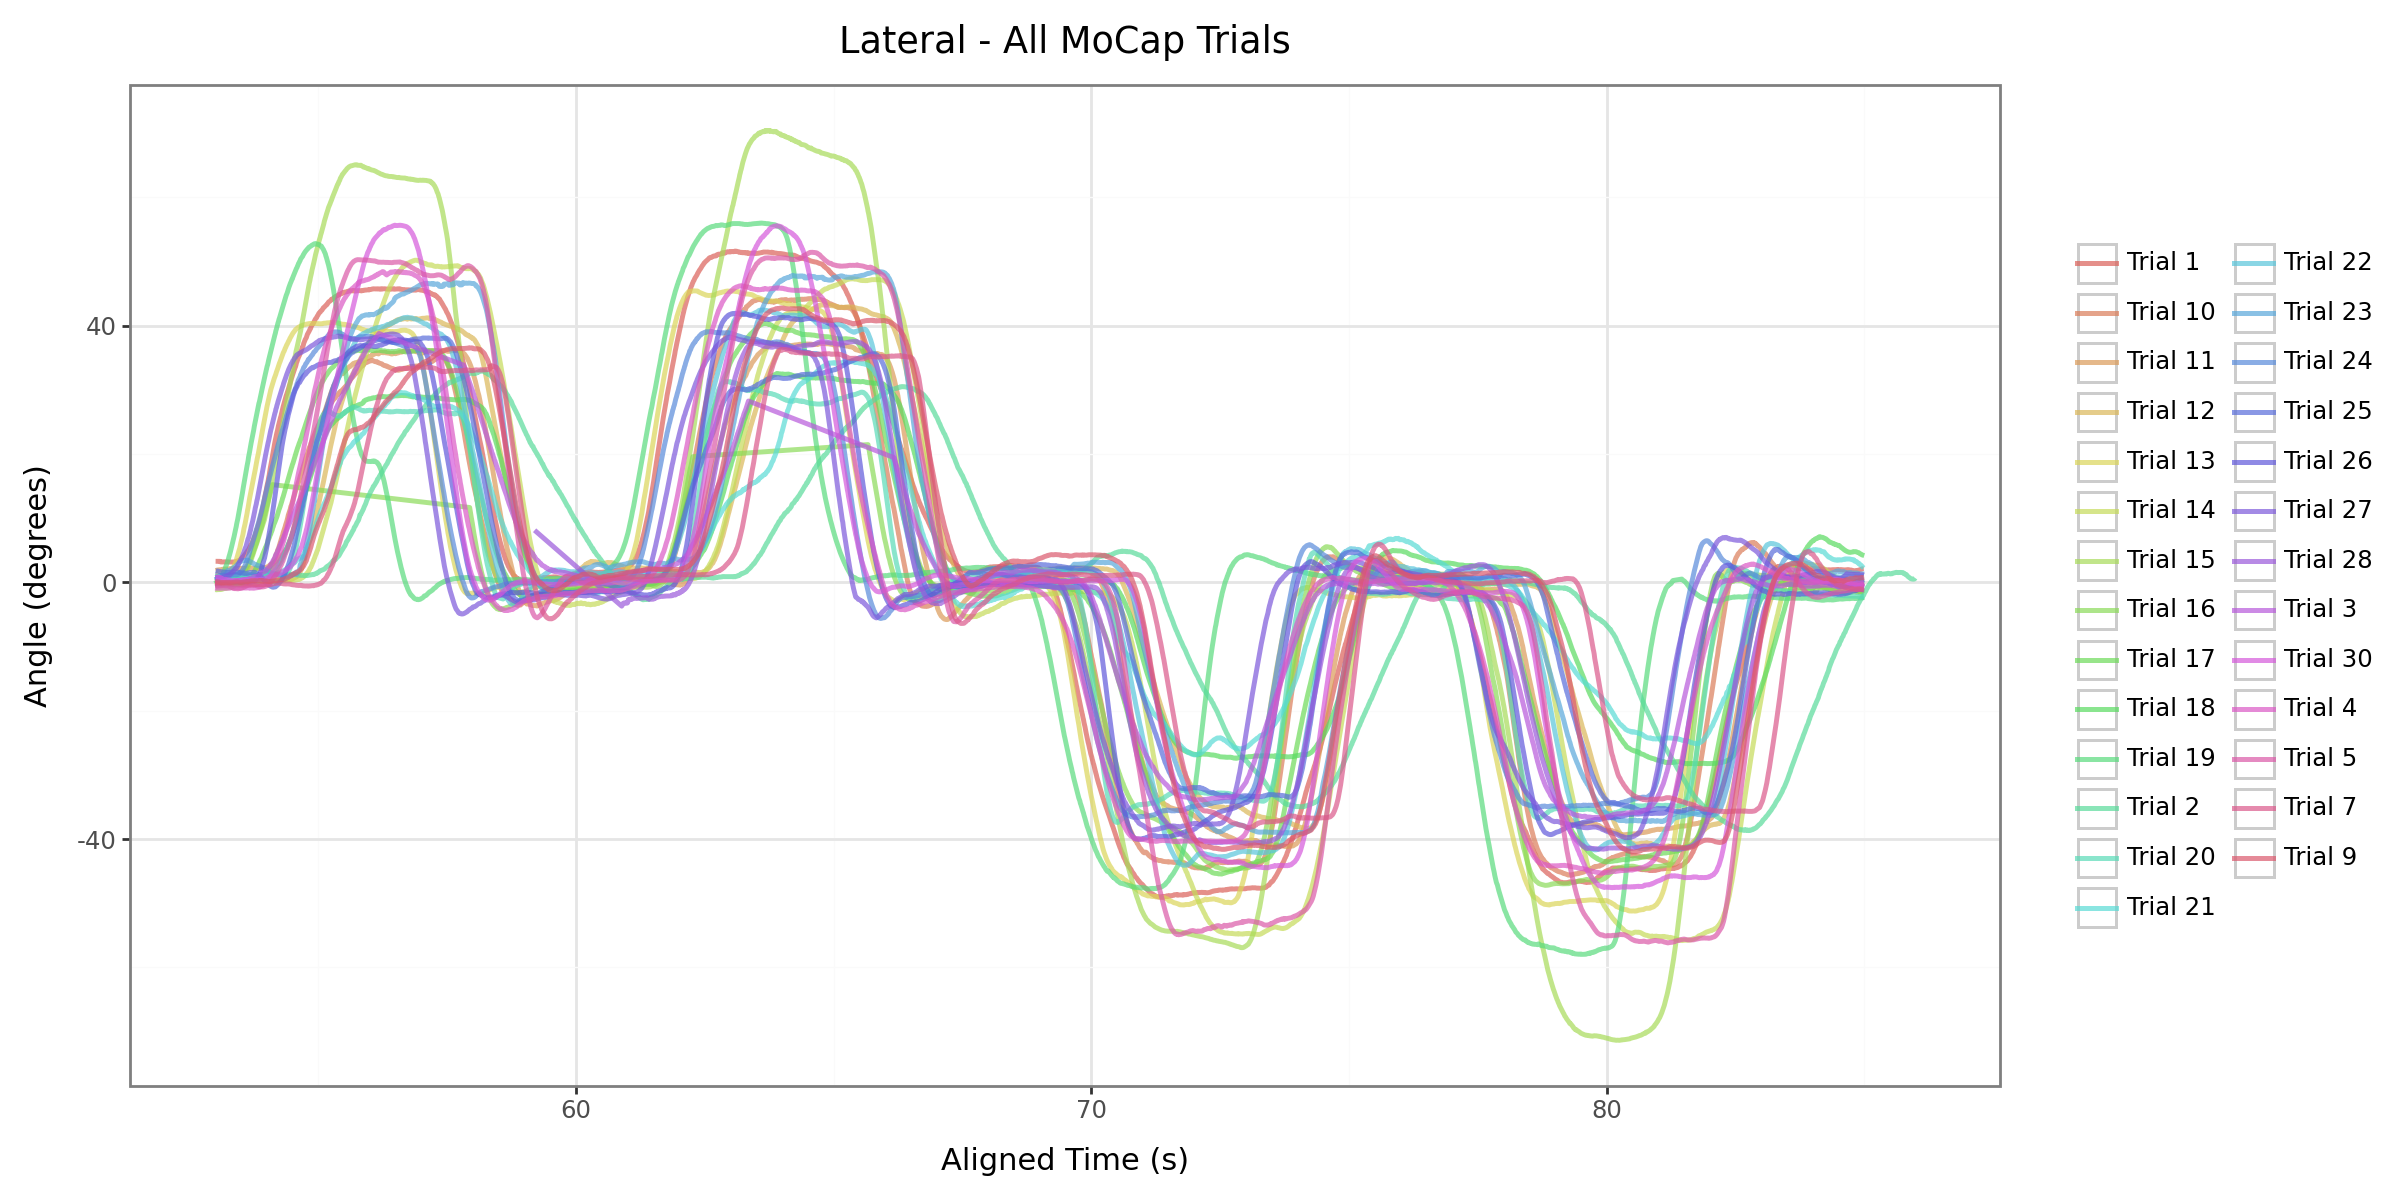

In [12]:
p = plot_all_device_data(aligned_lateral, 'Lateral', 'IMU')
p.show()

p = plot_all_device_data(aligned_lateral, 'Lateral', 'MoCap')
p.show()

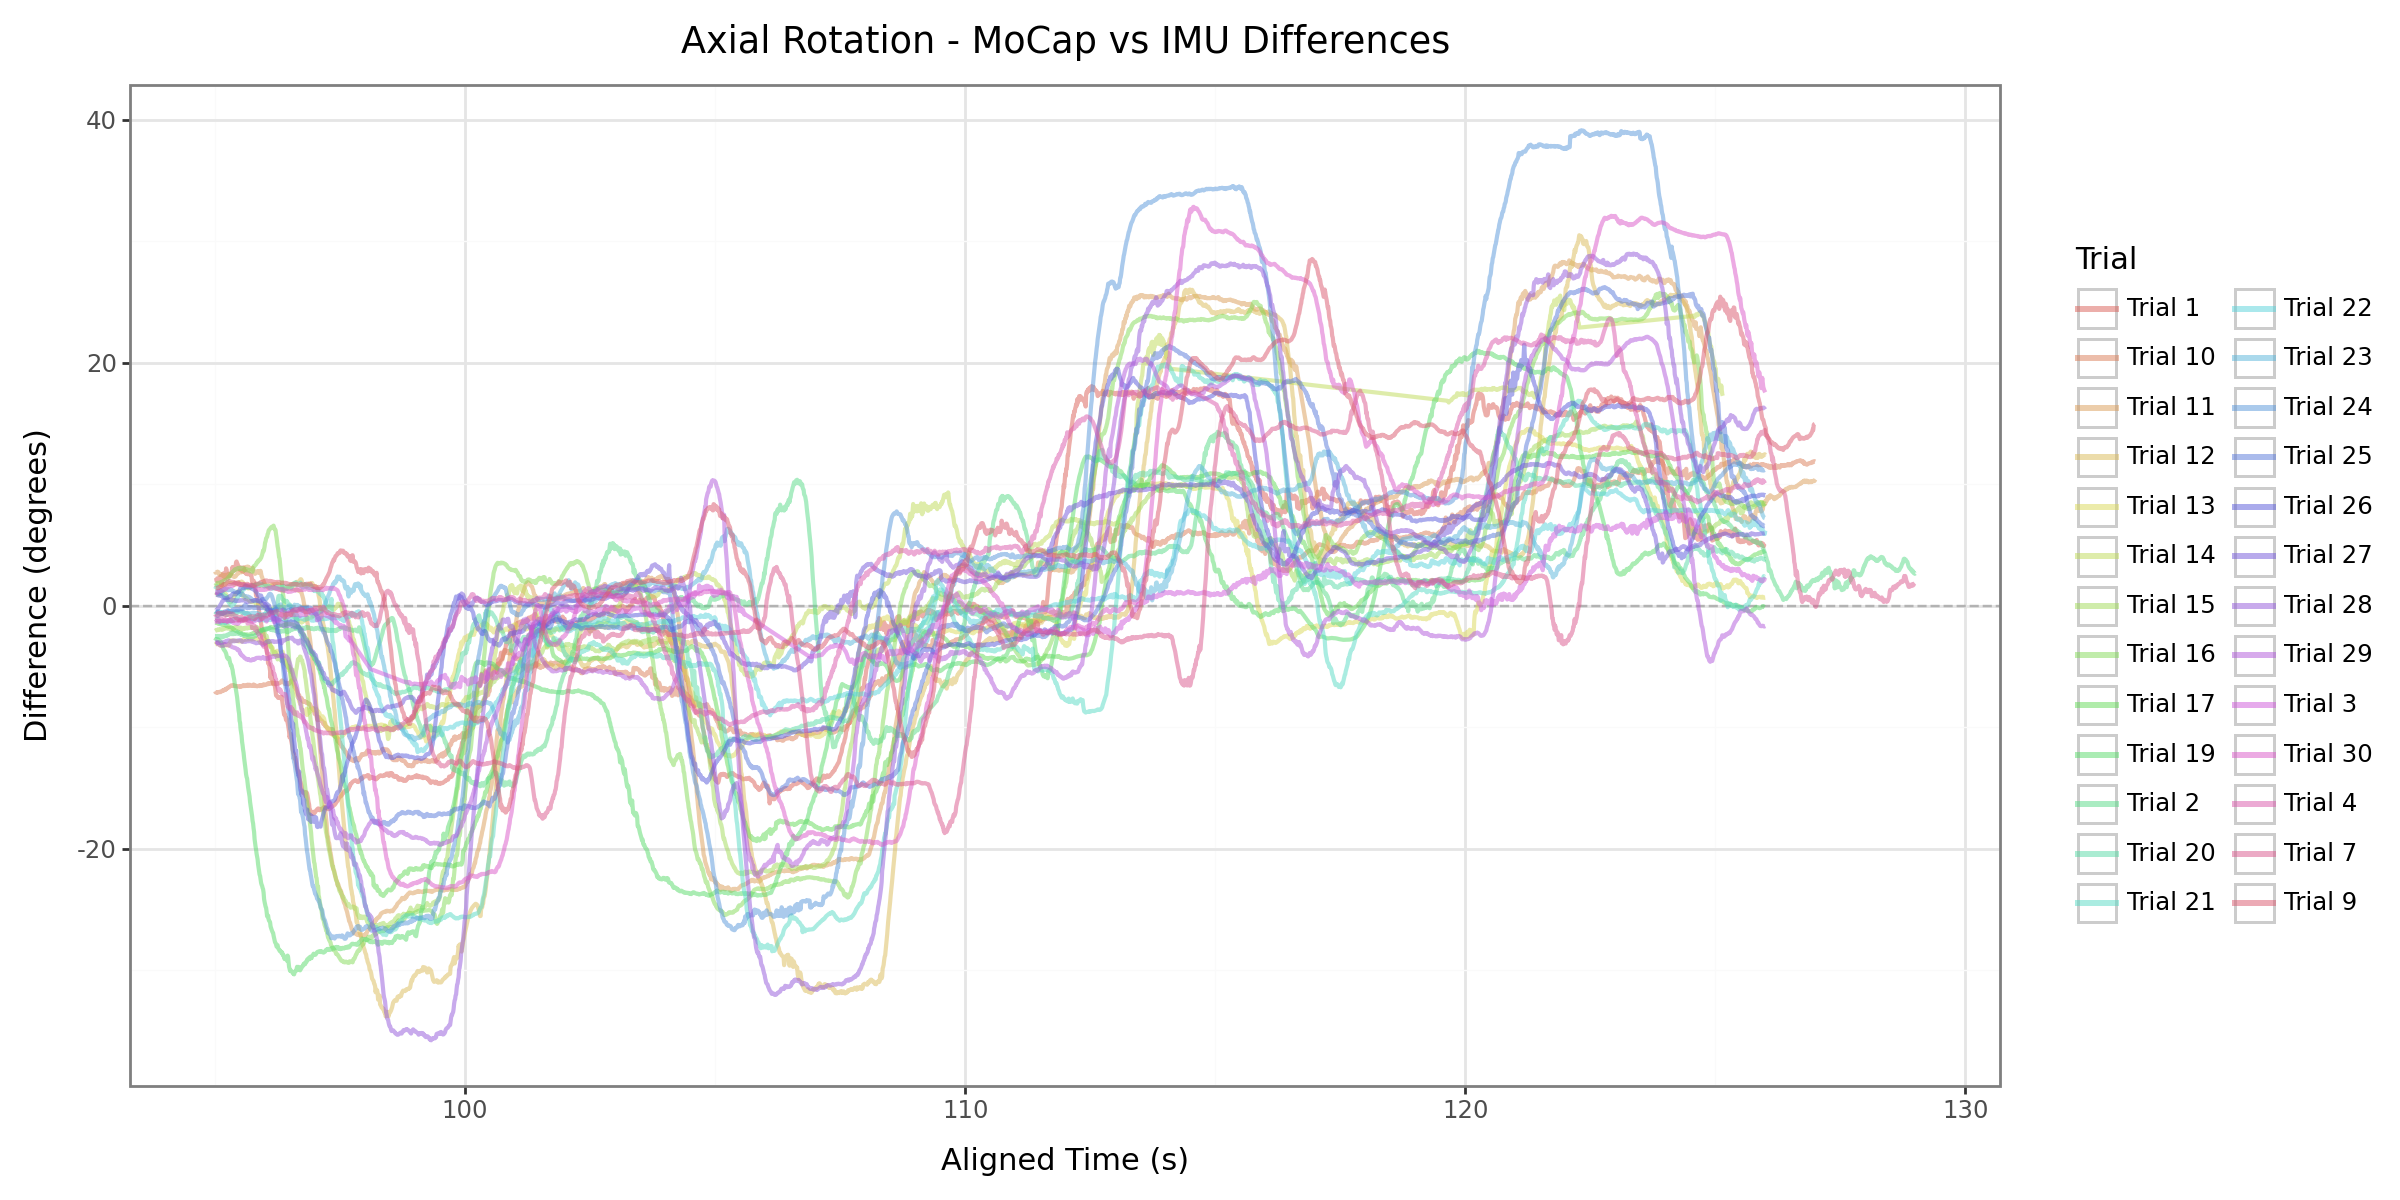

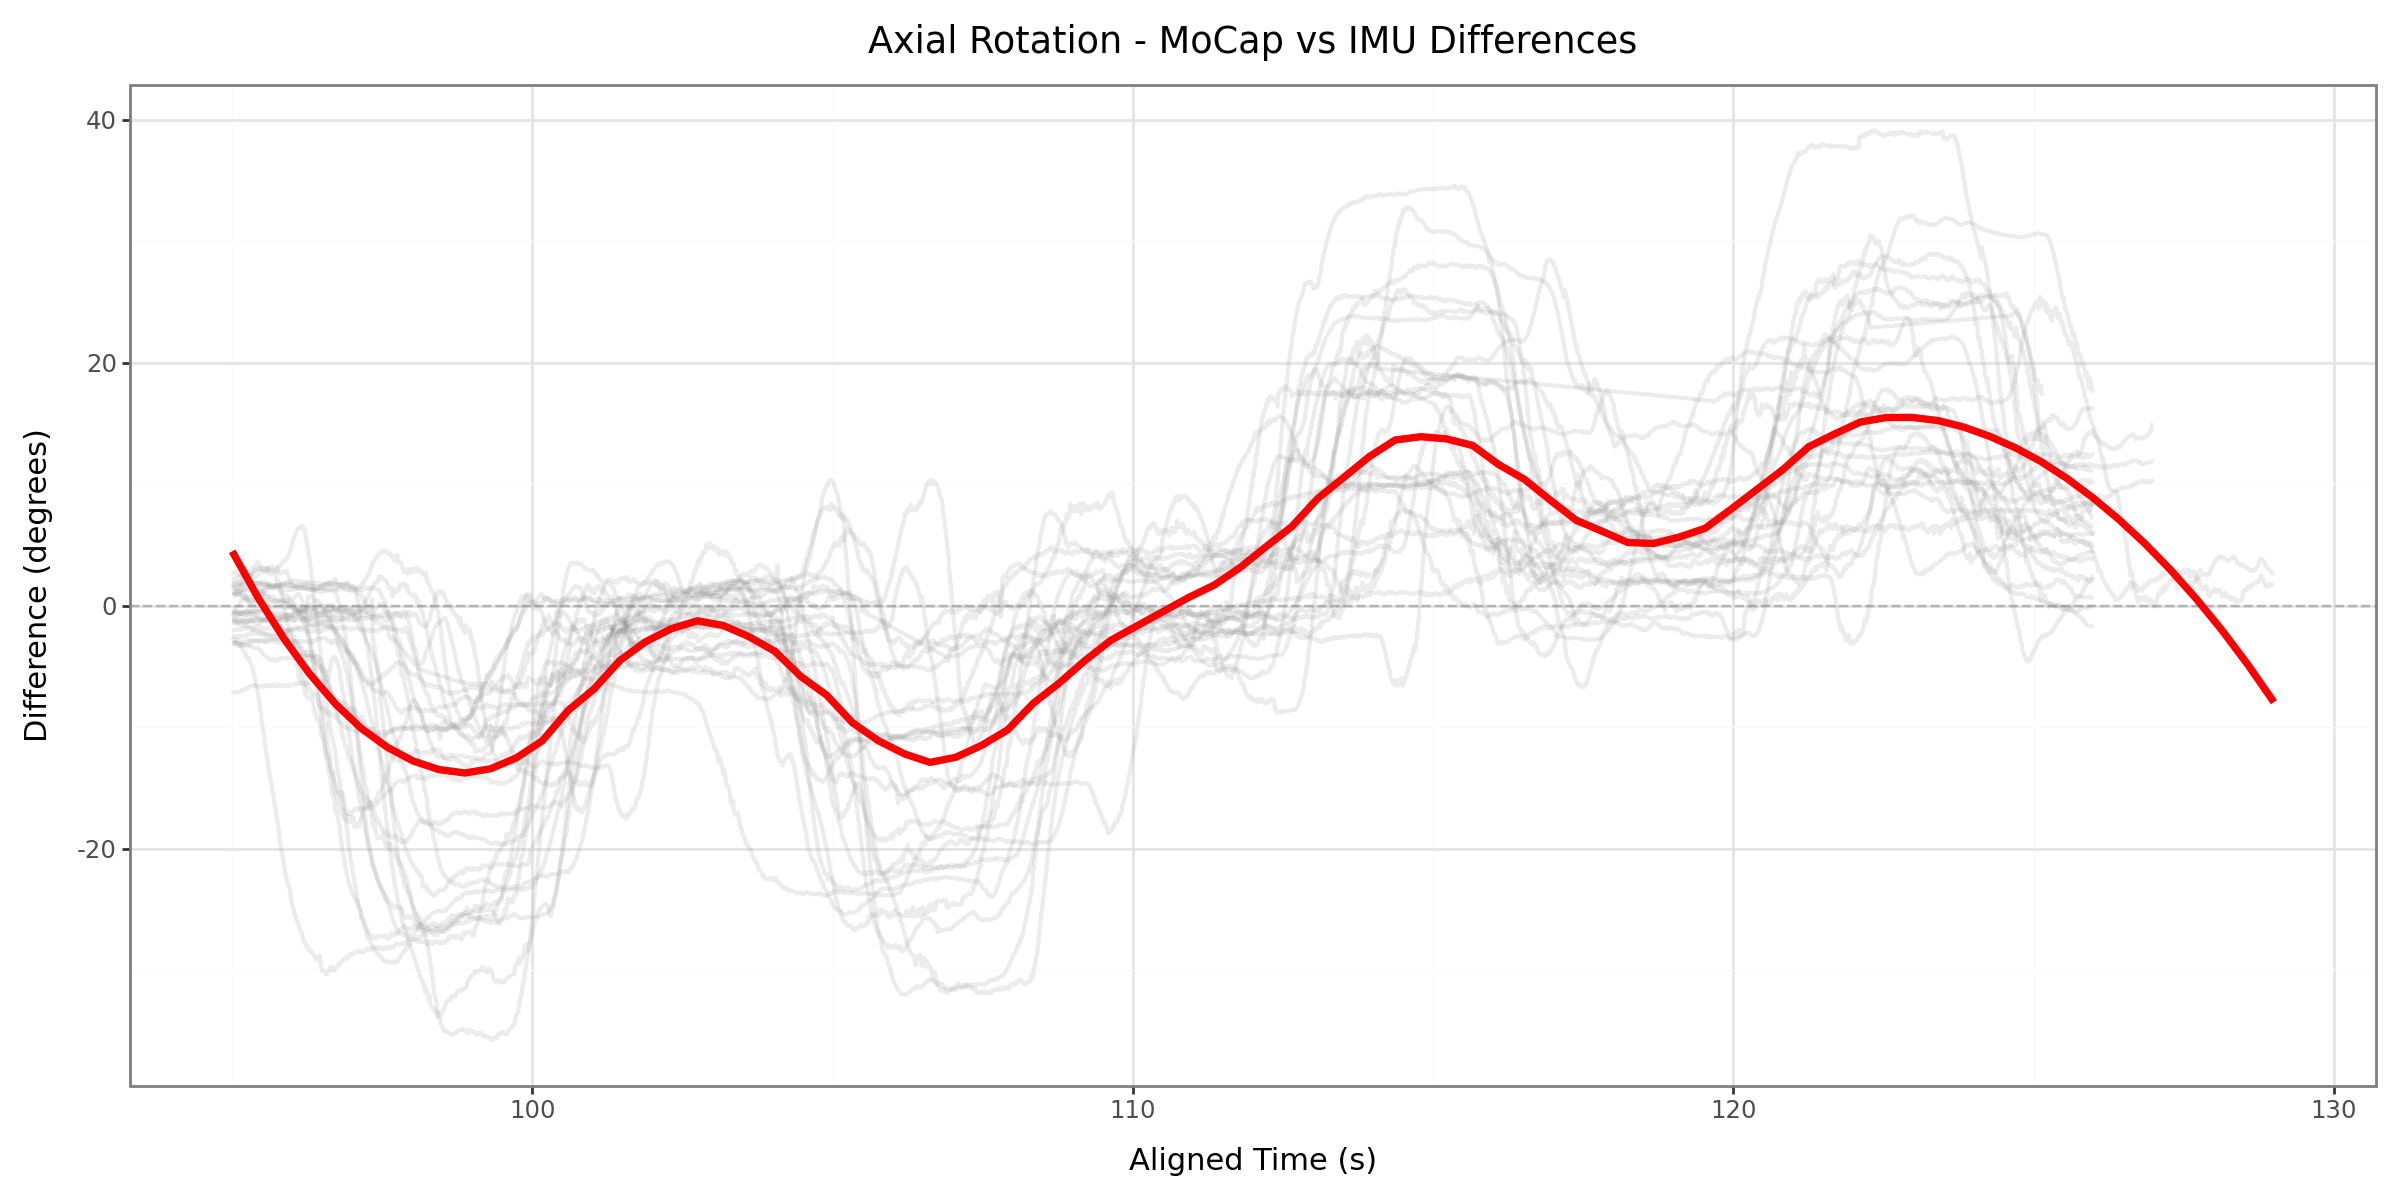

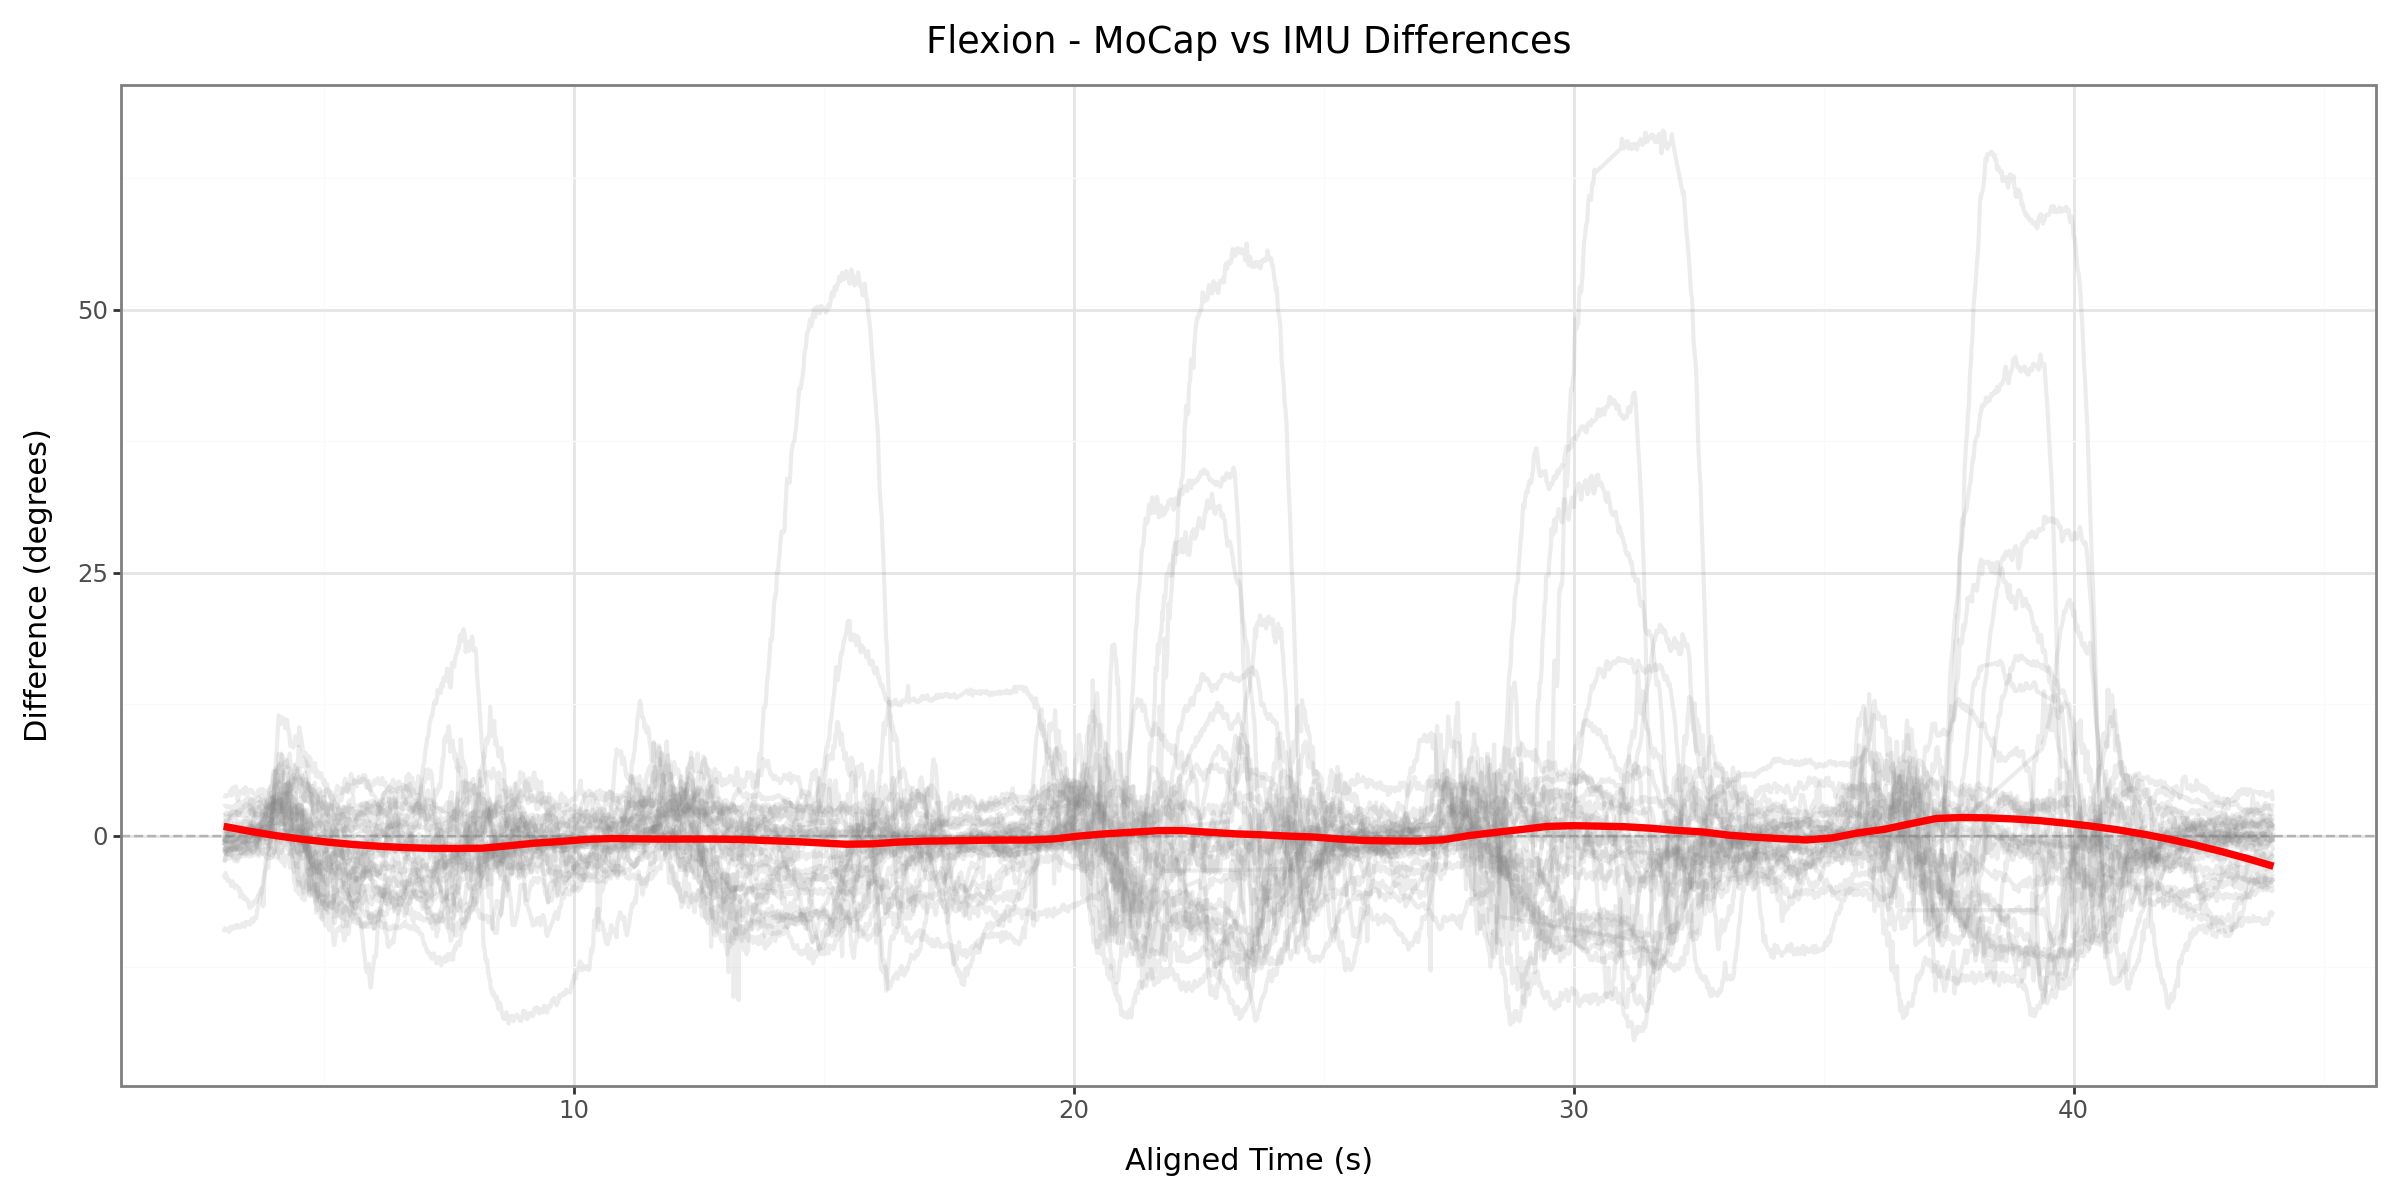

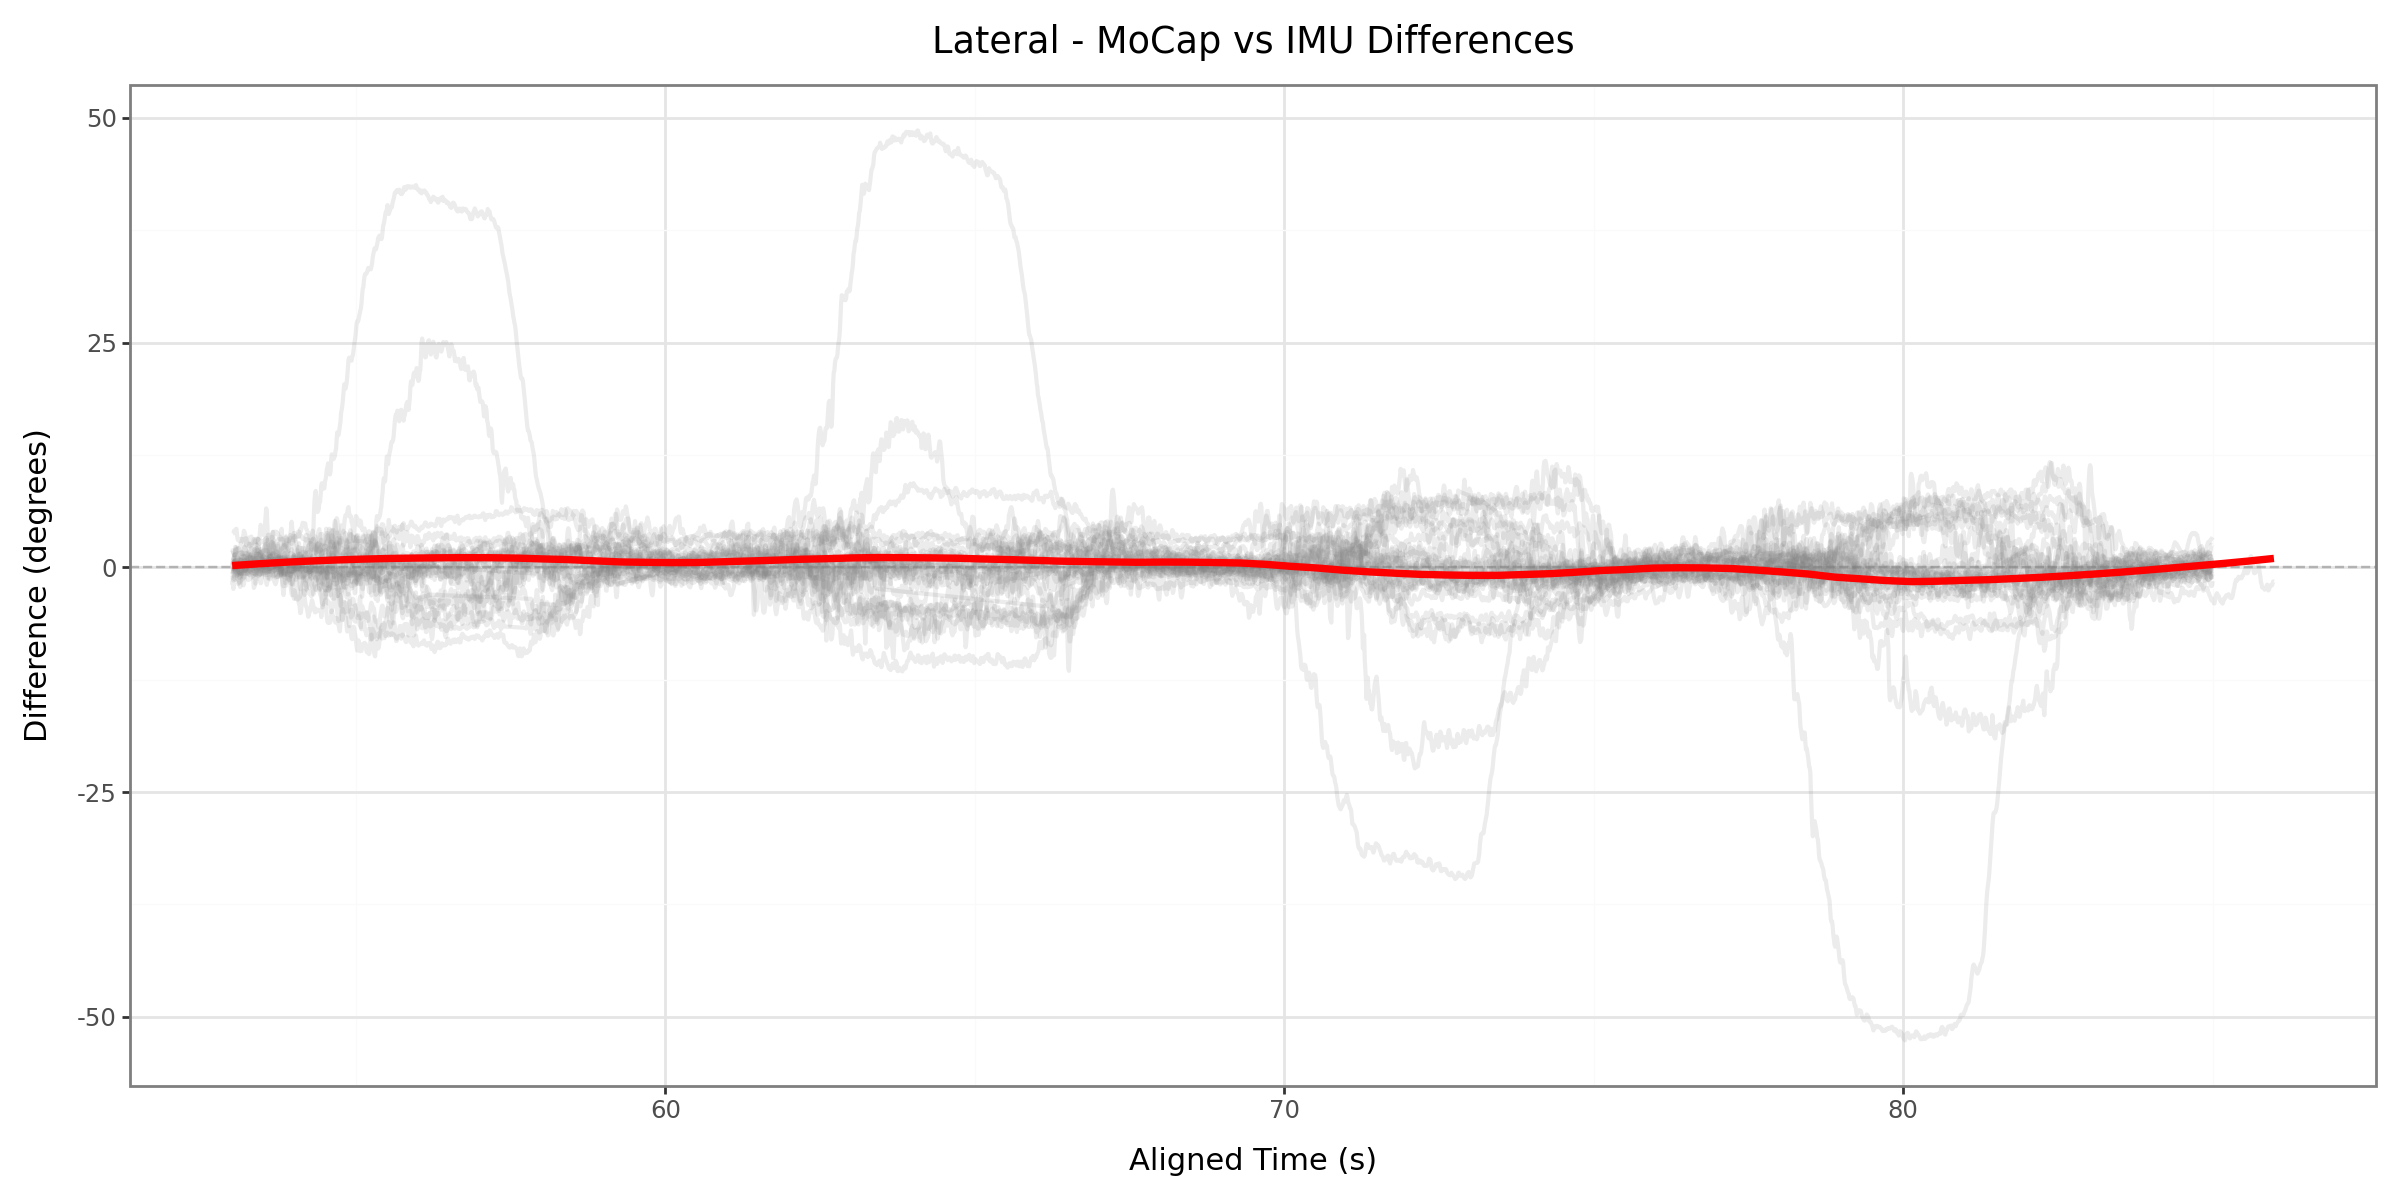

In [13]:
# Plot differences with LOESS smoothing
p = plot_differences_gg(aligned_axial, 'Axial Rotation', smooth=False)
p.show()

p = plot_differences_gg(aligned_axial, 'Axial Rotation', smooth=True)
p.show()

p = plot_differences_gg(aligned_flexion, 'Flexion', smooth=True)
p.show()

p = plot_differences_gg(aligned_lateral, 'Lateral', smooth=True)
p.show()

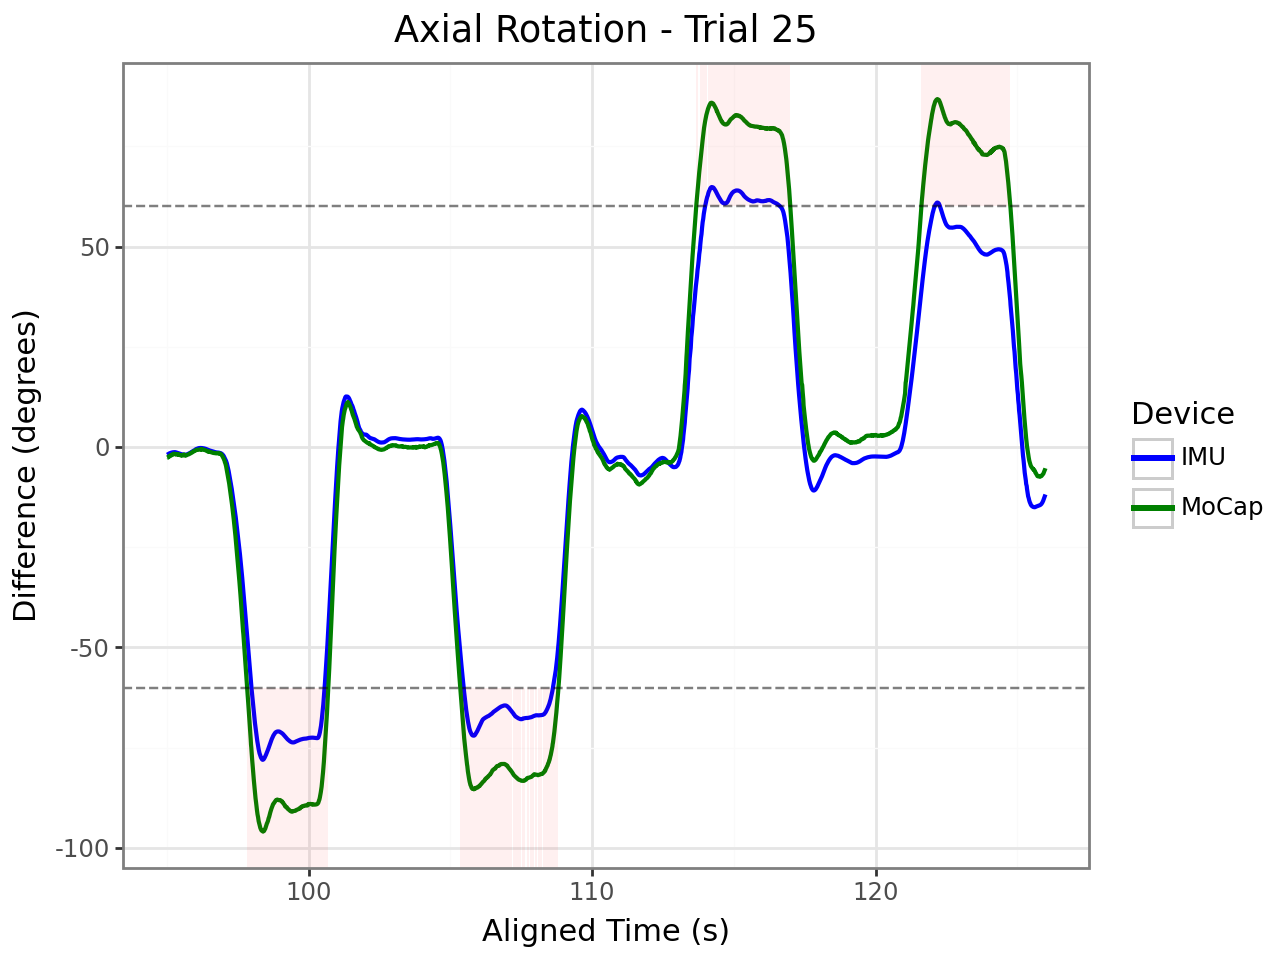

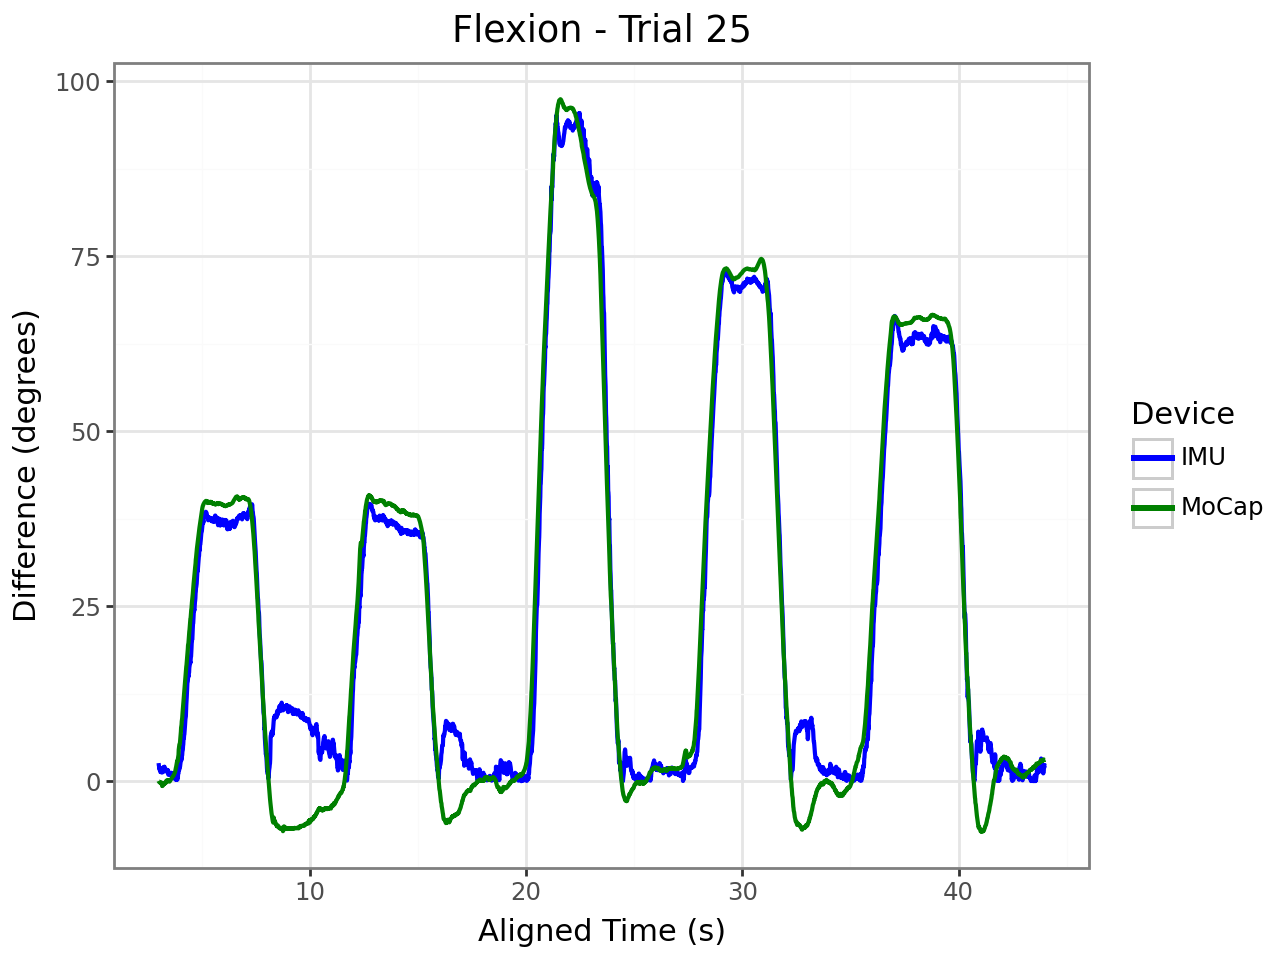

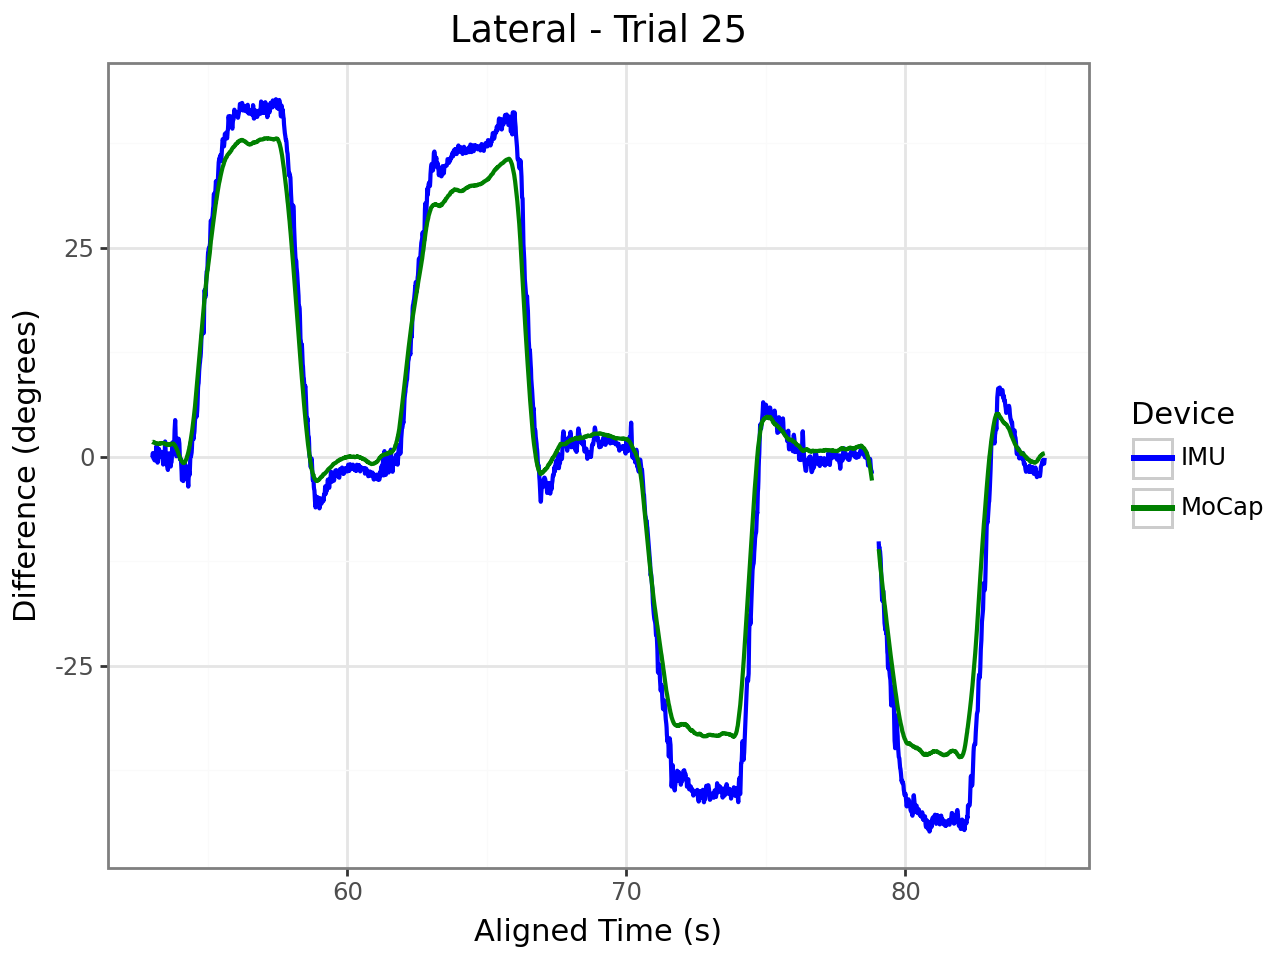

In [52]:
# Single trial plot
p = plot_single_trial_comparison_gg(aligned_axial, 'Axial Rotation', 25, highlight_thresholds=(-60, 60), highlight_alpha=0.06, gap_threshold=0.15)
p.show()

p = plot_single_trial_comparison_gg(aligned_flexion, 'Flexion', 25, gap_threshold=0.15)
p.show()

p = plot_single_trial_comparison_gg(aligned_lateral, 'Lateral', 25, gap_threshold=0.15)
p.show()

# DTW Investigation Plots


## Flexion

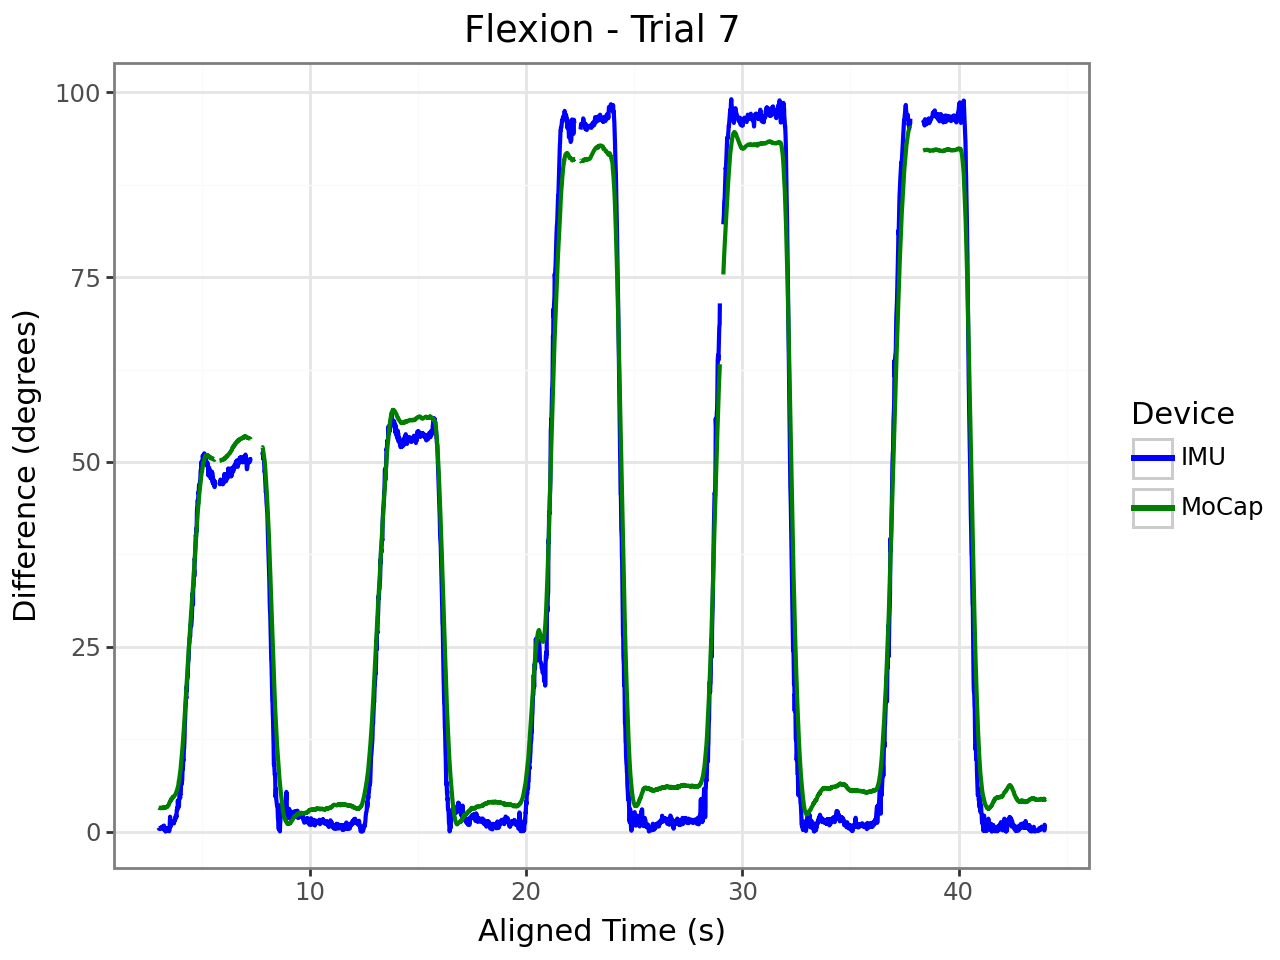

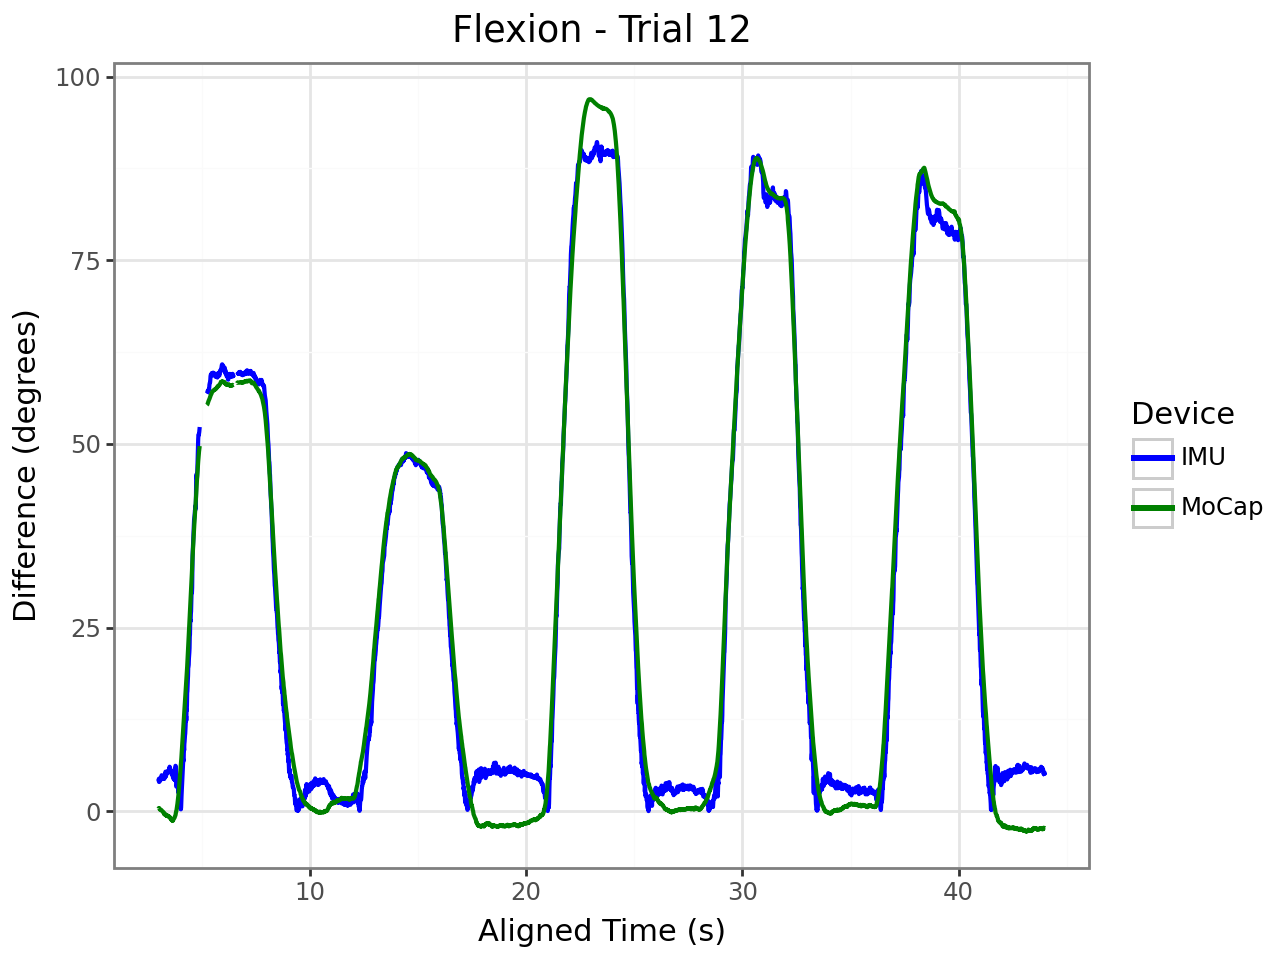

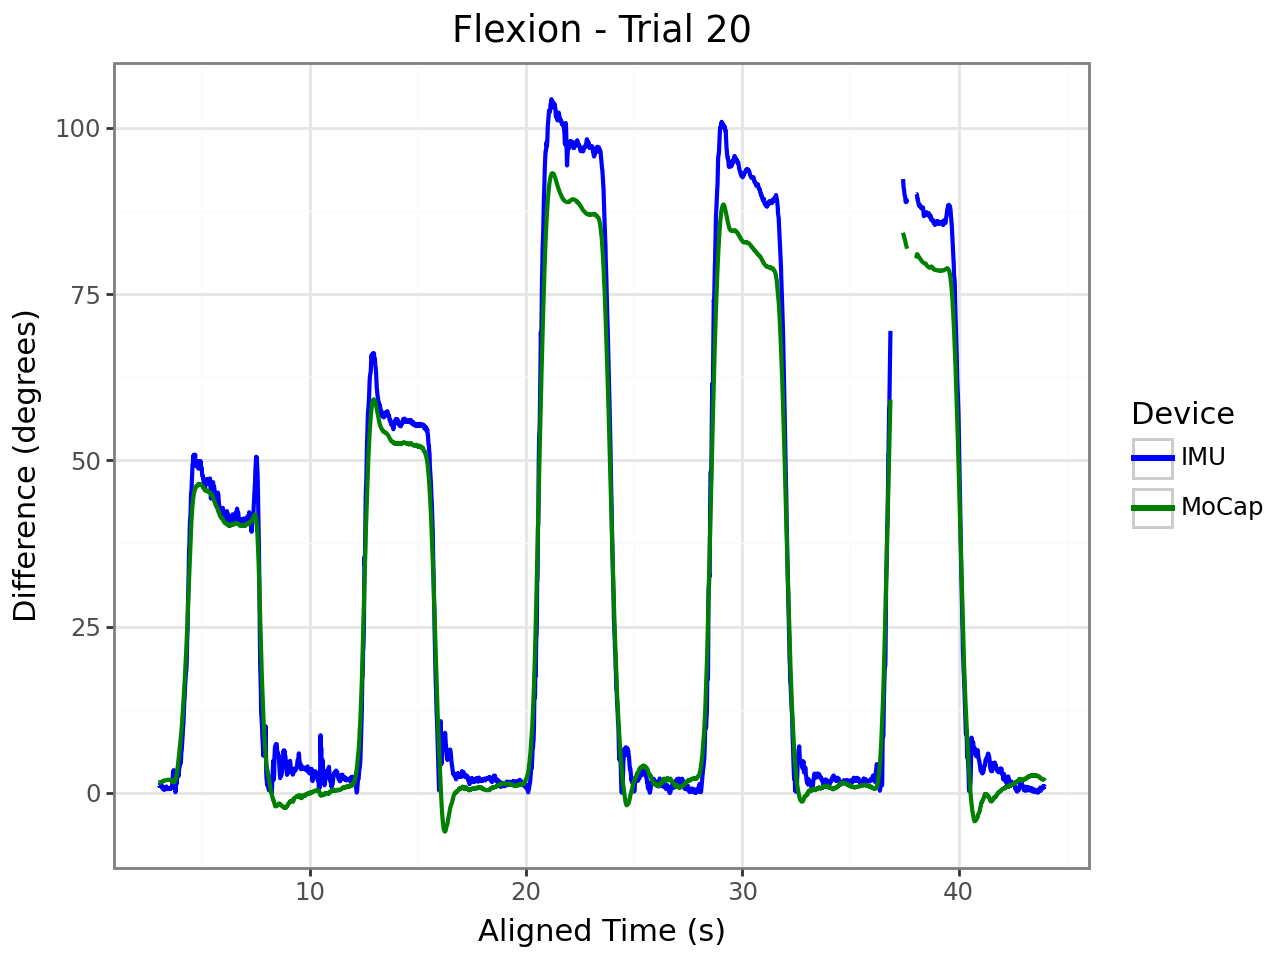

In [53]:
p = plot_single_trial_comparison_gg(aligned_flexion, 'Flexion', 7)
p.show()

p = plot_single_trial_comparison_gg(aligned_flexion, 'Flexion', 12)
p.show()

p = plot_single_trial_comparison_gg(aligned_flexion, 'Flexion', 20)
p.show()

## Lateral

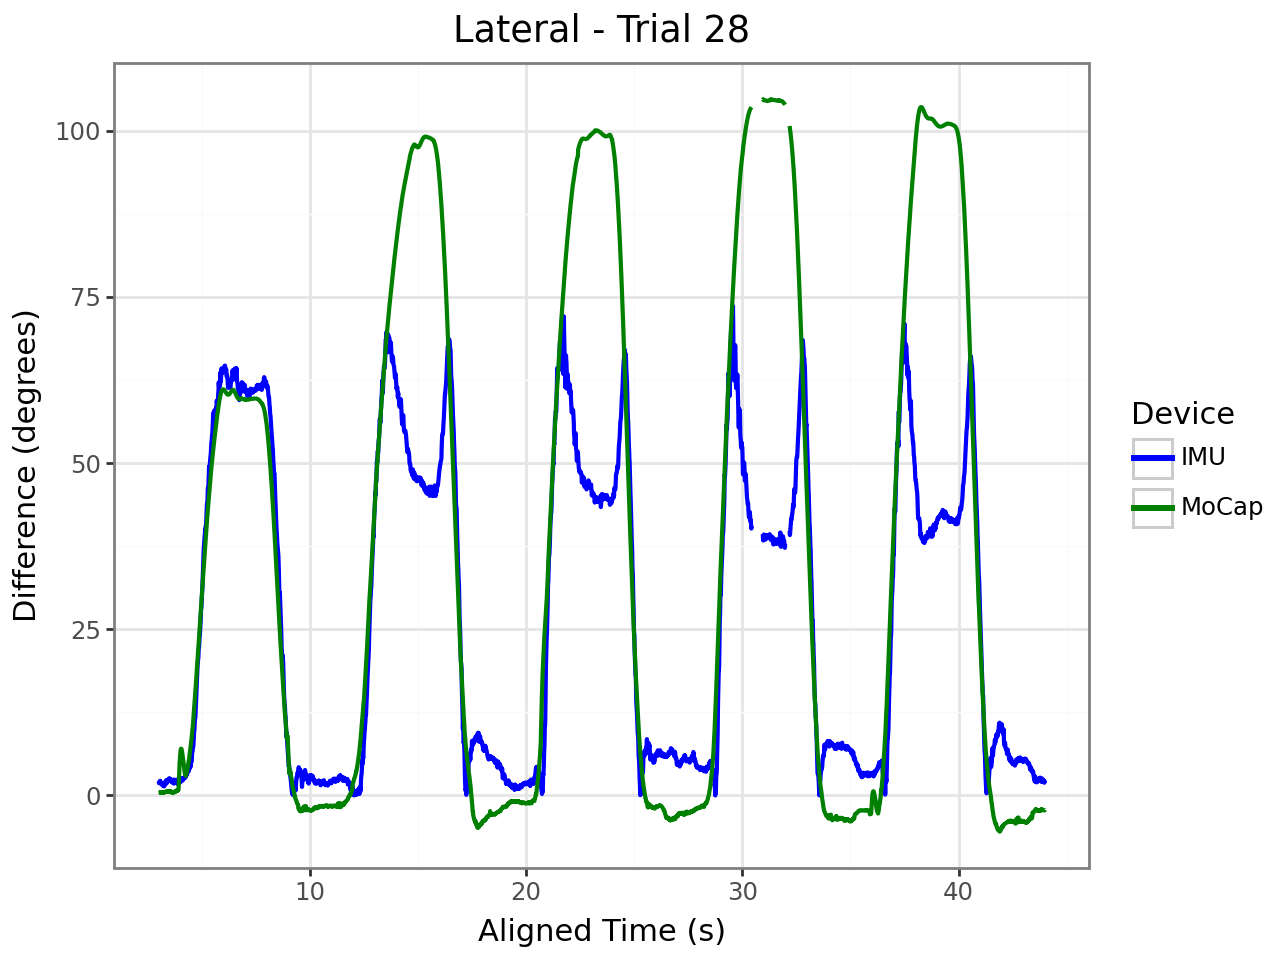

In [54]:
plot_single_trial_comparison_gg(aligned_flexion, 'Lateral', 28)

# Calculating Proportion of Time steps spent in a harmful postural angle of >= 60 degrees for Axial, Flexion, and Lateral

In [ ]:
THRESH = 60

# flatten & melt
frames = []
for movement, trial_dict in {
    'flexion': aligned_flexion,
    'lateral': aligned_lateral,
    'axial':   aligned_axial
}.items():
    for pid, df in trial_dict.items():
        df2 = df.copy()
        df2['participant'] = pid
        df2['movement']    = movement
        frames.append(df2)
all_df = pd.concat(frames, ignore_index=True)

# now we have a dataframe with the participant, movement, device, aligned time, trial number, and angle
long = all_df.melt(
    id_vars=['participant','movement','AlignedTime','TrialNumber'],
    value_vars=['Angle IMU (degrees)','Angle MoCap (degrees)'],
    var_name='device', value_name='angle'
)
long['device'] = long['device'].str.extract(r'(IMU|MoCap)')
long['bad']    = long['angle'] >= THRESH

# group by participant, movement, device
agg = (
    long
      .groupby(['participant','movement','device'])['bad']
      .agg(count_bad='sum',        # how many harmful timestep angles per person per device per response variable
           total_samples='size')  # how many total timesteps per person per device per response variable
      .reset_index()
)

# columns construction
wide = agg.pivot(
    index=['participant','movement'],
    columns='device',
    values=['count_bad','total_samples']
)
wide.columns = [f"{stat}_{dev}" for stat,dev in wide.columns]
wide = wide.reset_index()

# compute proportions
wide['prop_IMU']   = wide['count_bad_IMU']   / wide['total_samples_IMU']
wide['prop_MoCap'] = wide['count_bad_MoCap'] / wide['total_samples_MoCap']

print(wide[['participant','movement','prop_IMU','prop_MoCap']])

row = wide.query("participant==1 and movement=='axial'")
print(row[['count_bad_IMU','total_samples_IMU','prop_IMU']])
print(row[['count_bad_MoCap','total_samples_MoCap','prop_MoCap']])


    participant movement  prop_IMU  prop_MoCap
0             1    axial  0.212359    0.238648
1             1  flexion  0.252619    0.281432
2             1  lateral  0.000000    0.000000
3             2    axial  0.074005    0.091418
4             2  flexion  0.192960    0.191395
..          ...      ...       ...         ...
76           29    axial  0.050905    0.180048
77           29  flexion  0.336317    0.319949
78           30    axial  0.167516    0.210669
79           30  flexion  0.276751    0.271284
80           30  lateral  0.000000    0.000000

[81 rows x 4 columns]
   count_bad_IMU  total_samples_IMU  prop_IMU
0            622               2929  0.212359
   count_bad_MoCap  total_samples_MoCap  prop_MoCap
0              699                 2929    0.238648


for participant 1, axial



View Data Frame with counts of timesteps with harmful angles 

In [56]:
bad_counts = (
    long
      .groupby(['movement','device', 'participant'])['bad']
      .sum()            # count of True’s in each group
      .unstack(fill_value=0)
)

print(bad_counts)

participant       1    2     3    4     5    7    9     10    11   12  ...  \
movement device                                                        ...   
axial    IMU     622  238   398  204     0  366  597   587     0  478  ...   
         MoCap   699  294   417  562     0  612  663   626   490  549  ...   
flexion  IMU     868  740  1094  752  1011  768  401  1268  1386  821  ...   
         MoCap   967  734   785  660   999  761  397  1213  1144  801  ...   
lateral  IMU       0    0     0    0     0    0    0     0     0    0  ...   
         MoCap     0    0     0    0     0    0    0     0     0    0  ...   

participant        21    22   23    24   25    26    27    28    29    30  
movement device                                                            
axial    IMU      527   299  604   446  282   590   505   654   149   493  
         MoCap    588   517  629   636  636   618   566   708   527   620  
flexion  IMU     1111  1209  429  1418  804  1200  1093   555  1315  10

Vizualization of Proportions

   participant movement device  count_bad  n_total  prop_bad
0           10    axial    IMU        587     3056  0.192081
1           10    axial  MoCap        626     3056  0.204843
2           11    axial    IMU          0     3017  0.000000
3           11    axial  MoCap        490     3017  0.162413
4           12    axial    IMU        478     2958  0.161596


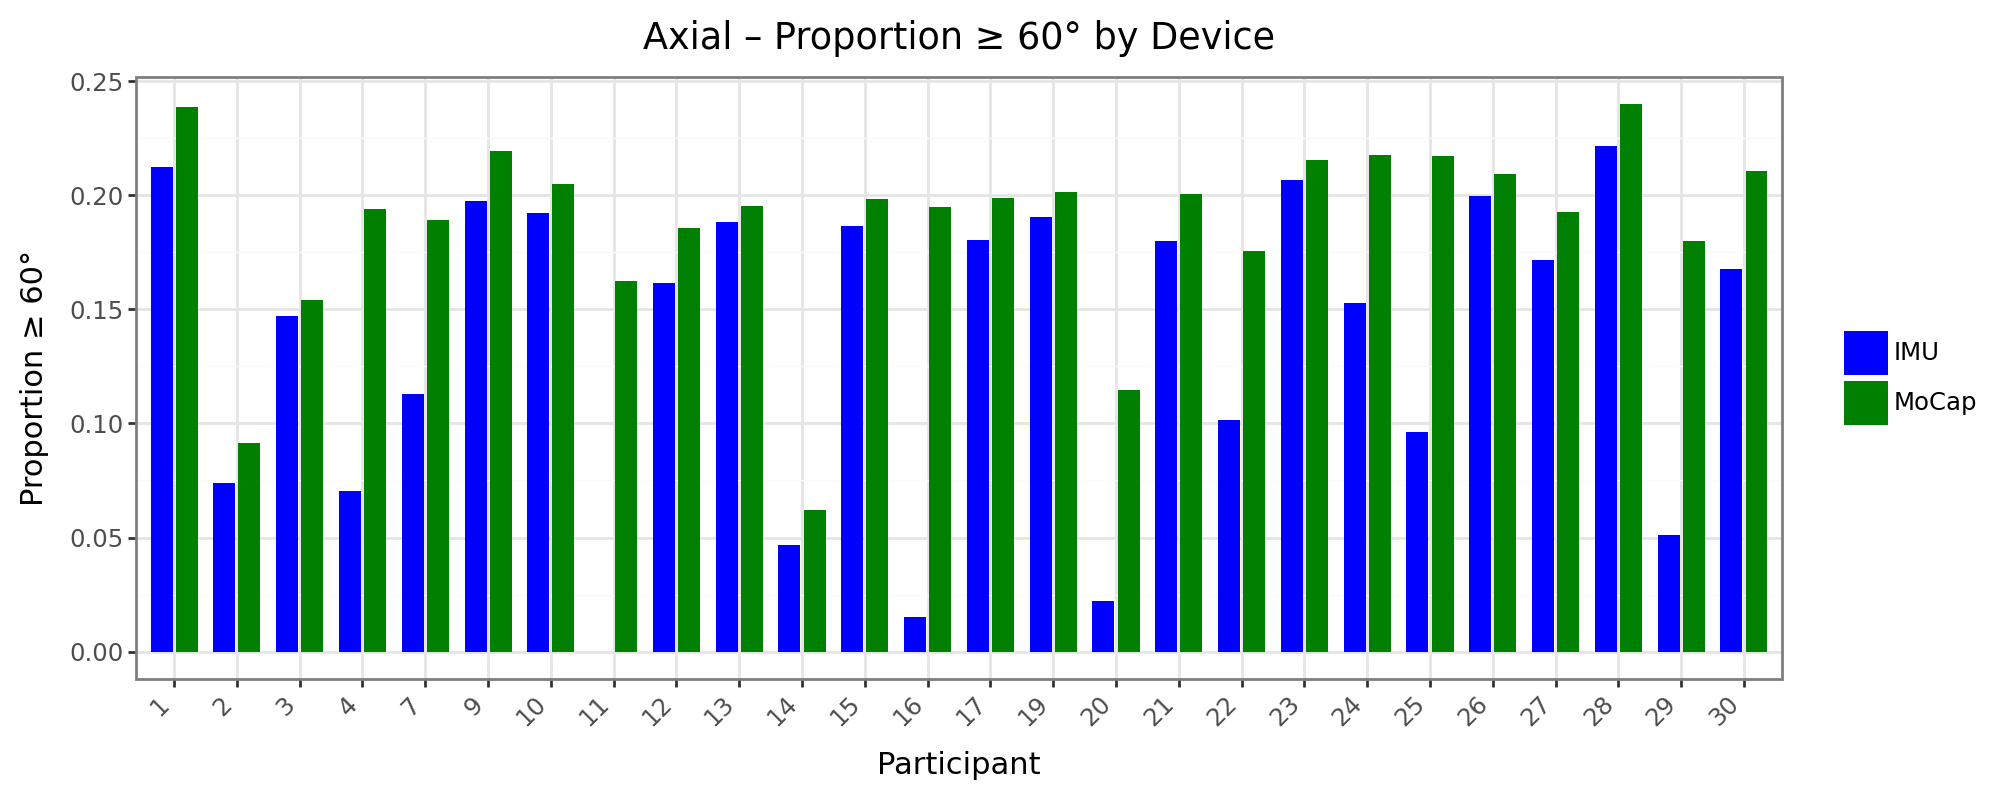

In [57]:
from plotnine import (
    ggplot, aes, geom_col, labs, theme_bw, theme,
    element_text, position_dodge, scale_fill_manual
)
THRESH = 60
records = []

# put your three movement‐dicts into one mapping
movements = {
    'axial':   aligned_axial,
    'flexion': aligned_flexion,
    'lateral': aligned_lateral
}

for movement, trial_dict in movements.items():
    for pid, df in trial_dict.items():
        n_total    = len(df)
        count_imu   = (df['Angle IMU (degrees)']   >= THRESH).sum()
        count_mocap = (df['Angle MoCap (degrees)'] >= THRESH).sum()

        # append one row per device
        records.append({
            'participant': pid,
            'movement':    movement,
            'device':      'IMU',
            'count_bad':   count_imu,
            'n_total':     n_total,
            'prop_bad':    count_imu / n_total
        })
        records.append({
            'participant': pid,
            'movement':    movement,
            'device':      'MoCap',
            'count_bad':   count_mocap,
            'n_total':     n_total,
            'prop_bad':    count_mocap / n_total
        })

prop_df = pd.DataFrame(records)
print(prop_df.head())



device_colors = {'IMU':'blue','MoCap':'green'}

def plot_movement_bars(mov, thresh=60):
    dfm = prop_df[prop_df['movement']==mov]
    return (
        ggplot(dfm, aes(x='factor(participant)', y='prop_bad', fill='device'))
      + geom_col(position=position_dodge(width=0.8), width=0.7)
      + labs(
            title=f'{mov.capitalize()} – Proportion ≥ {thresh}° by Device',
            x='Participant', y=f'Proportion ≥ {thresh}°',
            fill='Device'
        )
      + scale_fill_manual(values=device_colors)
      + theme_bw()
      + theme(
            figure_size=(10,4),
            legend_position='right',
            legend_title=element_blank(),
            axis_text_x=element_text(rotation=45, hjust=1)
        )
    )
p_axial   = plot_movement_bars('axial')
p_flexion = plot_movement_bars('flexion')
p_lateral = plot_movement_bars('lateral')

p_axial



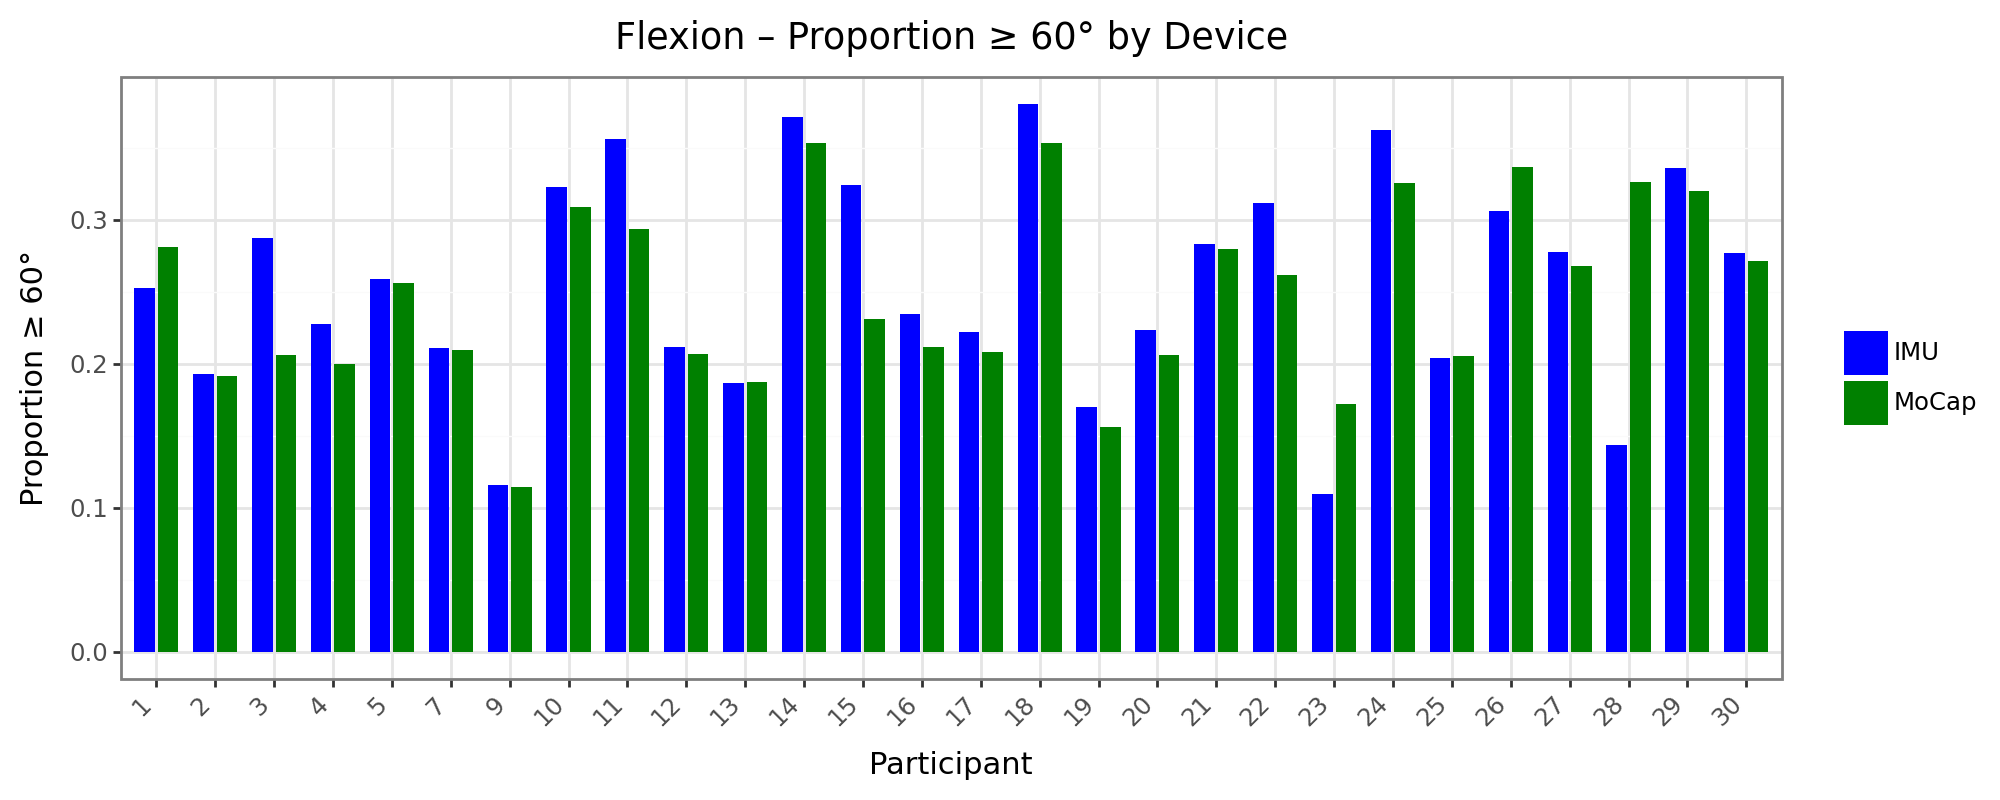

In [58]:
p_flexion

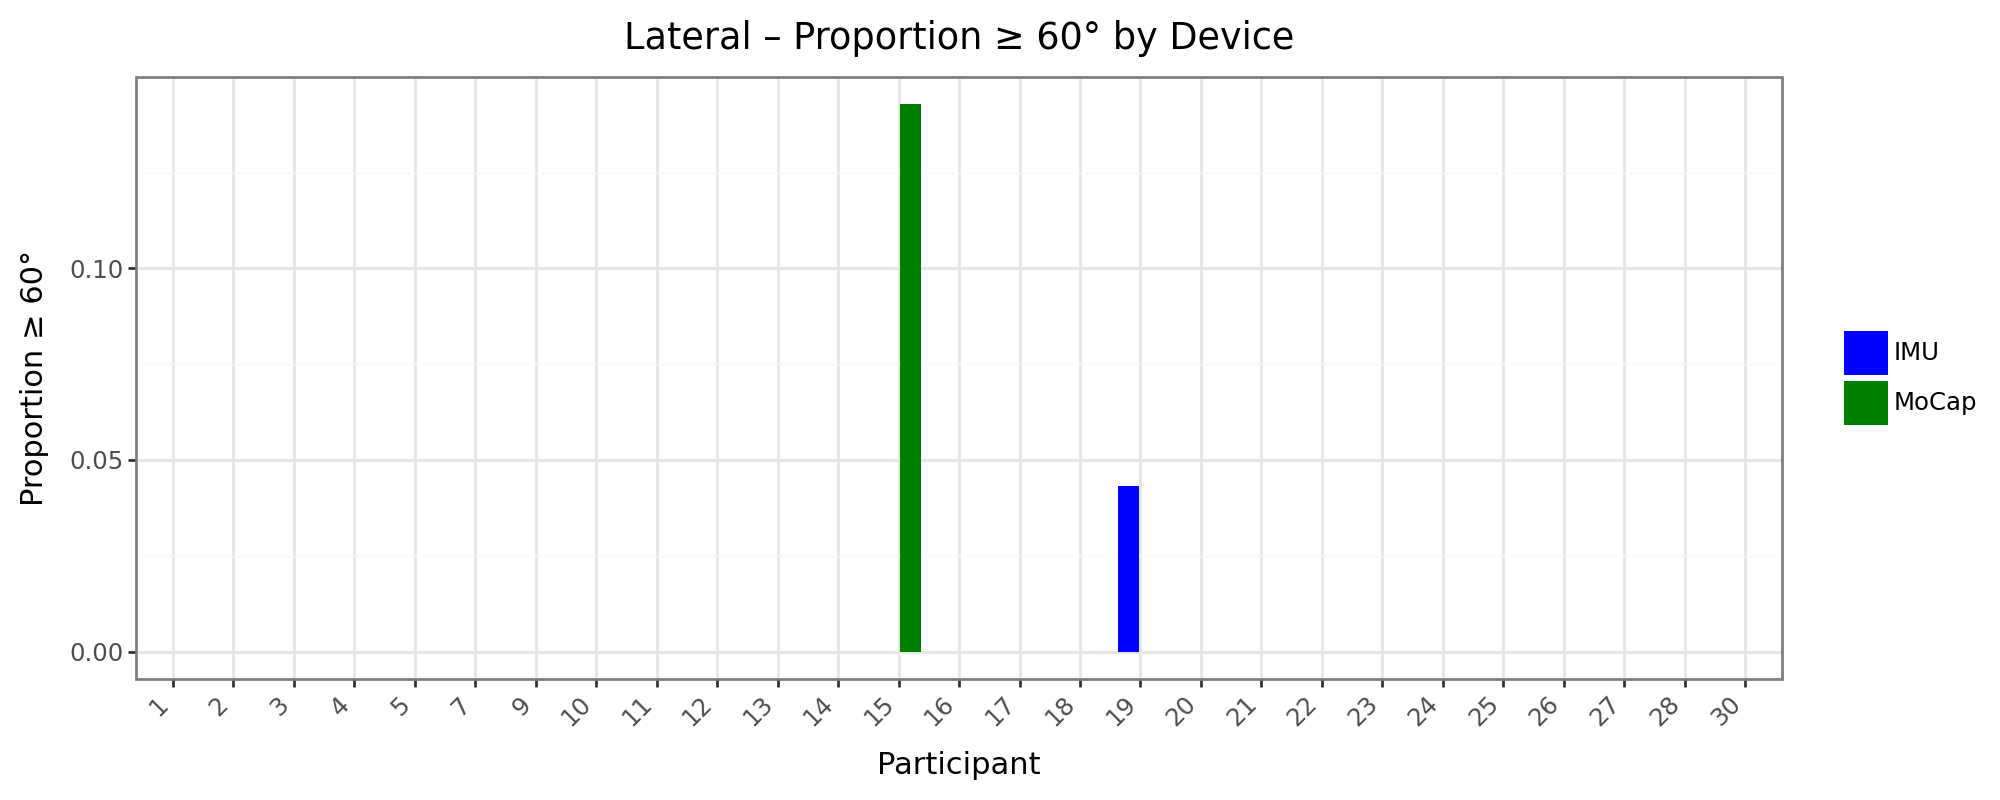

In [59]:
p_lateral

Paired t-test and Wilcoxon rigned-rank test for Axial, Flexion, and Lateral

In [60]:
counts_mov = (
    long
      .loc[long['bad']]   # keep only the “bad” rows
      .groupby(['participant','movement','device'])
      .size()             # count rows
      .unstack(fill_value=0)  # wide: columns IMU, MoCap
      .rename(columns={'IMU':'count_IMU','MoCap':'count_MoCap'})
      .reset_index()
)

# compute totals + proportions
counts_mov['total_bad']   = counts_mov['count_IMU'] + counts_mov['count_MoCap']
counts_mov['prop_IMU']    = counts_mov['count_IMU']  / counts_mov['total_bad']
counts_mov['prop_MoCap']  = counts_mov['count_MoCap']/ counts_mov['total_bad']

# pick the columns you want
result = counts_mov[[
    'participant','movement',
    'count_IMU','count_MoCap','total_bad',
    'prop_IMU','prop_MoCap'
]]

print(result.head())

device  participant movement  count_IMU  count_MoCap  total_bad  prop_IMU  \
0                 1    axial        622          699       1321  0.470855   
1                 1  flexion        868          967       1835  0.473025   
2                 2    axial        238          294        532  0.447368   
3                 2  flexion        740          734       1474  0.502035   
4                 3    axial        398          417        815  0.488344   

device  prop_MoCap  
0         0.529145  
1         0.526975  
2         0.552632  
3         0.497965  
4         0.511656  


In [61]:
import numpy as np
from scipy.stats            import ttest_rel, wilcoxon
from statsmodels.stats.multitest import fdrcorrection

#  Extract your movement list
movements = counts_mov['movement'].unique()

# Run paired tests and get p-values
p_t   = []   # for paired t-test
p_w   = []   # for Wilcoxon
for mov in movements:
    sub = counts_mov[counts_mov['movement']==mov].sort_values('participant')
    x = sub['prop_IMU'].values
    y = sub['prop_MoCap'].values

    # paired t-test
    _, pt = ttest_rel(x, y)
    p_t.append(pt)

    # Wilcoxon signed-rank (zero_method='wilcox' when you have ties)
    try:
        _, pw = wilcoxon(x, y)
    except ValueError:
        pw = np.nan  # if all diffs are zero
    p_w.append(pw)

# 3) FDR‐correct each series of three p-values
rej_t, p_t_adj = fdrcorrection(p_t, alpha=0.05)
rej_w, p_w_adj = fdrcorrection(p_w, alpha=0.05)

# 4) Summarize results
results = pd.DataFrame({
    'movement':      movements,
    'p_t':           p_t,
    'p_t_adj':       p_t_adj,
    'signif_t':      rej_t,
    'p_wilcoxon':    p_w,
    'p_w_adj':       p_w_adj,
    'signif_w':      rej_w
})

print(results)


  movement       p_t   p_t_adj  signif_t    p_wilcoxon       p_w_adj  signif_w
0    axial  0.000591  0.001773      True  2.980232e-08  8.940697e-08      True
1  flexion  0.649311  0.973967     False  1.459887e-02  2.189830e-02      True
2  lateral  1.000000  1.000000     False  1.000000e+00  1.000000e+00     False


McNemar's test for Axial, Flexion, and Lateral

In [62]:
from statsmodels.stats.contingency_tables import mcnemar
from statsmodels.stats.multitest      import fdrcorrection

# to long form
df_pairs = (
    long
      .pivot_table(
          index=['participant','movement','AlignedTime','TrialNumber'],
          columns='device',
          values='bad'
      )
      .reset_index()
      .rename(columns={'IMU':'bad_IMU','MoCap':'bad_MoCap'})
)

#  convert to boolean
df_pairs['bad_IMU']   = df_pairs['bad_IMU'].astype(bool)
df_pairs['bad_MoCap'] = df_pairs['bad_MoCap'].astype(bool)

# Run McNemar’s exact test for each movement
records = []
for mov in df_pairs['movement'].unique():
    dfm = df_pairs[df_pairs['movement']==mov]
    
    # a = IMU-only bad, b = both bad, c = both good, d = MoCap-only bad
    b = (dfm['bad_IMU']   & dfm['bad_MoCap']).sum()
    a = (dfm['bad_IMU']   & ~dfm['bad_MoCap']).sum()
    d = (~dfm['bad_IMU']  & dfm['bad_MoCap']).sum()
    c = len(dfm) - (a + b + d)
    
    table = [[b, c],
             [a, d]]
    res = mcnemar(table, exact=True)
    
    records.append({
        'movement':       mov,
        'both_bad (b)':   int(b),
        'both_good (c)':  int(c),
        'IMU_only (a)':   int(a),
        'MoCap_only (d)': int(d),
        'p_raw':          res.pvalue
    })

res_df = pd.DataFrame(records)

# control fdr rate
rej, p_adj = fdrcorrection(res_df['p_raw'], alpha=0.05)
res_df['p_FDR']      = p_adj
res_df['significant'] = rej

print(res_df)

   

  movement  both_bad (b)  both_good (c)  IMU_only (a)  MoCap_only (d)  p_raw  \
0    axial         10425          61779             8            3902    0.0   
1  flexion         25148          78096          2326            1489    0.0   
2  lateral             0          79809           131             437    0.0   

   p_FDR  significant  
0    0.0         True  
1    0.0         True  
2    0.0         True  
